In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns

import keras as ks
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping

from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from pandas_summary import DataFrameSummary

from tqdm import tqdm


C:\Users\leo_g\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data_path = 'input/'
df = pd.read_csv(data_path +'SerializerBenchmark_Log.csv')


In [4]:
DataFrameSummary(df).summary().T

,count,mean,std,min,25%,50%,75%,max,counts,uniques,missing,missing_perc,types
StringOrStream,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29400,2,0,0%,bool
TestDataName,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29400,8,0,0%,categorical
Repetitions,29400,100,0,100,100,100,100,100,29400,1,0,0%,constant
RepetitionIndex,29400,49.5,28.8666,0,24.75,49.5,74.25,99,29400,100,0,0%,numeric
SerializerName,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29400,28,0,0%,categorical
TimeSer,29400,1463.39,55978.1,2,29,79,701,7.31992e+06,29400,3606,0,0%,numeric
TimeDeser,29400,3862.28,52626,1,32,91,994,6.33412e+06,29400,5021,0,0%,numeric
Size,29400,10908.4,22434.7,4,178,1006.5,7858,136588,29400,395,0,0%,numeric
TimeSerAndDeser,29400,5325.67,81004.6,3,62,189,1765.25,7.54532e+06,29400,6351,0,0%,numeric
OpPerSecSer,29400,320184,626685,1,14265,126582,344827,5e+06,29400,3450,0,0%,numeric


In [7]:
df.head()

,StringOrStream,TestDataName,Repetitions,RepetitionIndex,SerializerName,TimeSer,TimeDeser,Size,TimeSerAndDeser,OpPerSecSer,OpPerSecDeser,OpPerSecSerAndDeser
0,string,Person,100,0,MS Binary,40713,2237,2336,42950,245,4470,232
1,string,Person,100,0,MS Bond Compact,485191,5206,692,490397,20,1920,20
2,string,Person,100,0,MS Bond Fast,178866,3228,896,182094,55,3097,54
3,string,Person,100,0,MS Bond Json,339498,46660,1010,386158,29,214,25
4,string,Person,100,0,MS DataContract,95887,14457,2700,110344,104,691,90


# Questions

Let's define the terms: **Speed** as the OpPer* measurements [OpPerSecSer, OpPerSecDeser, OpPerSecSerAndDeser];
**S** as Serialization; **D** as Deserialization; **S&D** Serialization and Deserialization.
Because the OpPer* are the inverse values to the Time* values, we will mosltly analyze only OpPer* values.
We have several categorial features: [TestDataName, SerializerName, StringOrStream]

- How the Speed related to the to the Repetion counter?
- How the Speed related to to the Categorial Features? 


# Outliers
In our case outliers represent the test measurements when GC performed garbage collections. These test cycles distort the correct picture and we'd rather remove such measurements.

In [131]:
from scipy import stats

x =  df[(np.abs(stats.zscore(df[['OpPerSecSer', 'OpPerSecDeser', 'OpPerSecSerAndDeser']])) < 3).all(axis=1)]
print(df.shape, df_cleaned.shape)

(29400, 12) (28229, 12)


In [132]:
cols = df.columns; cols
test_data_names = df.TestDataName.unique(); test_data_names
ser_names = df.SerializerName.unique(); ser_names

array(['MS Binary', 'MS Bond Compact', 'MS Bond Fast', 'MS Bond Json',
       'MS DataContract', 'MS DataContract Json', 'MS JavaScript',
       'MS XmlSerializer', 'fastJson', 'Jil', 'JsonFx',
       'Json.Net (Helper)', 'Json.Net', 'HaveBoxJSON', 'FsPickler',
       'FsPicklerJson', 'MessageShark', 'MsgPack', 'NetJSON',
       'NetSerializer', 'NFX.Slim', 'ProtoBuf', 'ServiceStack Json',
       'ServiceStack Type', 'WireSerializer', 'NFX.Json',
       'SharpSerializer', 'Salar.Bois'], dtype=object)

# Some Review of Distributions

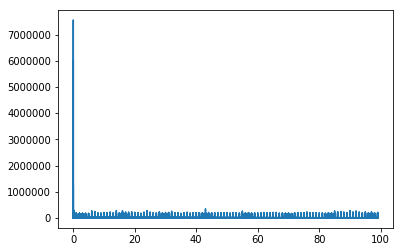

In [81]:
plt.plot(x.RepetitionIndex, x.TimeSerAndDeser)

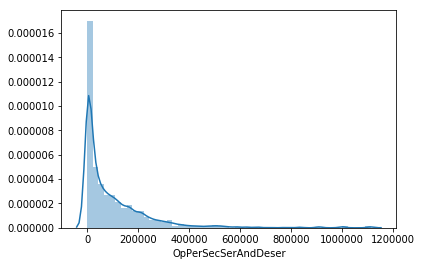

In [82]:
sns.distplot(x.OpPerSecSerAndDeser)

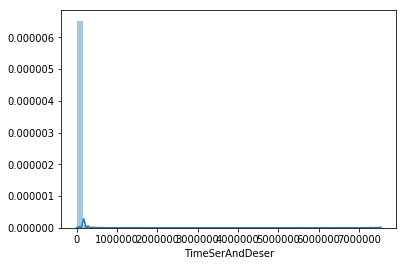

In [83]:
sns.distplot(x.TimeSerAndDeser)

In [84]:
#df[df.StringOrStream == 'Stream'].TimeSerAndDeser.value_counts(bins=10), df[df.StringOrStream == 'Stream'].TimeSerAndDeser.value_counts(bins=10).sum()
df.TimeSerAndDeser.value_counts(bins=10), df.TimeSerAndDeser.value_counts(bins=10).sum()

((-7542.318, 754534.7]     29393
 (754534.7, 1509066.4]         3
 (6790788.3, 7545320.0]        2
 (5281724.9, 6036256.6]        2
 (6036256.6, 6790788.3]        0
 (4527193.2, 5281724.9]        0
 (3772661.5, 4527193.2]        0
 (3018129.8, 3772661.5]        0
 (2263598.1, 3018129.8]        0
 (1509066.4, 2263598.1]        0
 Name: TimeSerAndDeser, dtype: int64, 29400)

In [67]:
x.TimeSerAndDeser.value_counts(bins=10), x.TimeSerAndDeser.value_counts(bins=10).sum()

((-327.84299999999996, 33693.2]    13044
 (168430.0, 202114.2]                114
 (134745.8, 168430.0]                 62
 (33693.2, 67377.4]                   16
 (202114.2, 235798.4]                 15
 (235798.4, 269482.6]                  7
 (303166.8, 336851.0]                  1
 (269482.6, 303166.8]                  1
 (67377.4, 101061.6]                   1
 (101061.6, 134745.8]                  0
 Name: TimeSerAndDeser, dtype: int64, 13261)

In [88]:
x[x.TimeSerAndDeser<60000].TimeSerAndDeser.value_counts(bins=10), x[x.TimeSerAndDeser<60000].TimeSerAndDeser.value_counts(bins=10).sum()

((-47.556, 5664.5]     25565
 (5664.5, 11320.0]      1656
 (11320.0, 16975.5]      310
 (16975.5, 22631.0]      168
 (22631.0, 28286.5]       28
 (39597.5, 45253.0]       22
 (28286.5, 33942.0]       13
 (33942.0, 39597.5]        7
 (50908.5, 56564.0]        4
 (45253.0, 50908.5]        4
 Name: TimeSerAndDeser, dtype: int64, 27777)

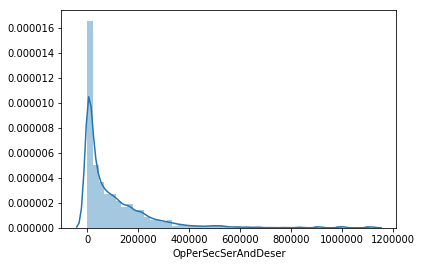

In [89]:
sns.distplot(x[x.TimeSerAndDeser<60000].OpPerSecSerAndDeser)

## Conclusion
So we are going to clean up outliers not only by z-score but also by x.TimeSerAndDeser<60000 filter.

In [144]:
def clean_up_outliers(df):
    print(df.shape)
    x =  df[(np.abs(stats.zscore(df[['OpPerSecSer', 'OpPerSecDeser', 'OpPerSecSerAndDeser']])) < 3).all(axis=1)]
    print(x.shape)
    x = x[x.TimeSerAndDeser<60000]
    print(x.shape)
    return x

In [145]:
x = clean_up_outliers(df)

(29400, 12)
(28229, 12)
(27777, 12)


# Compare Serializers for the Different Data Types

In [134]:
test_data_names, len(test_data_names)

(array(['Person', 'Integer', 'String Array', 'Simple Object', 'Telemetry',
        'EDI_X12_835', 'EDI_X12_835 No Atributes', 'MsgBatching'],
       dtype=object), 8)

In [135]:
def plot_serializers(test_data_name):
    x_td = x[x.TestDataName == test_data_name]
    ax = sns.factorplot(x="OpPerSecSerAndDeser", y="SerializerName", hue="StringOrStream", 
                        data=x_td, kind="bar", size=15, aspect=1.5)
    _ = ax.fig.suptitle(test_data_name, fontsize=25)

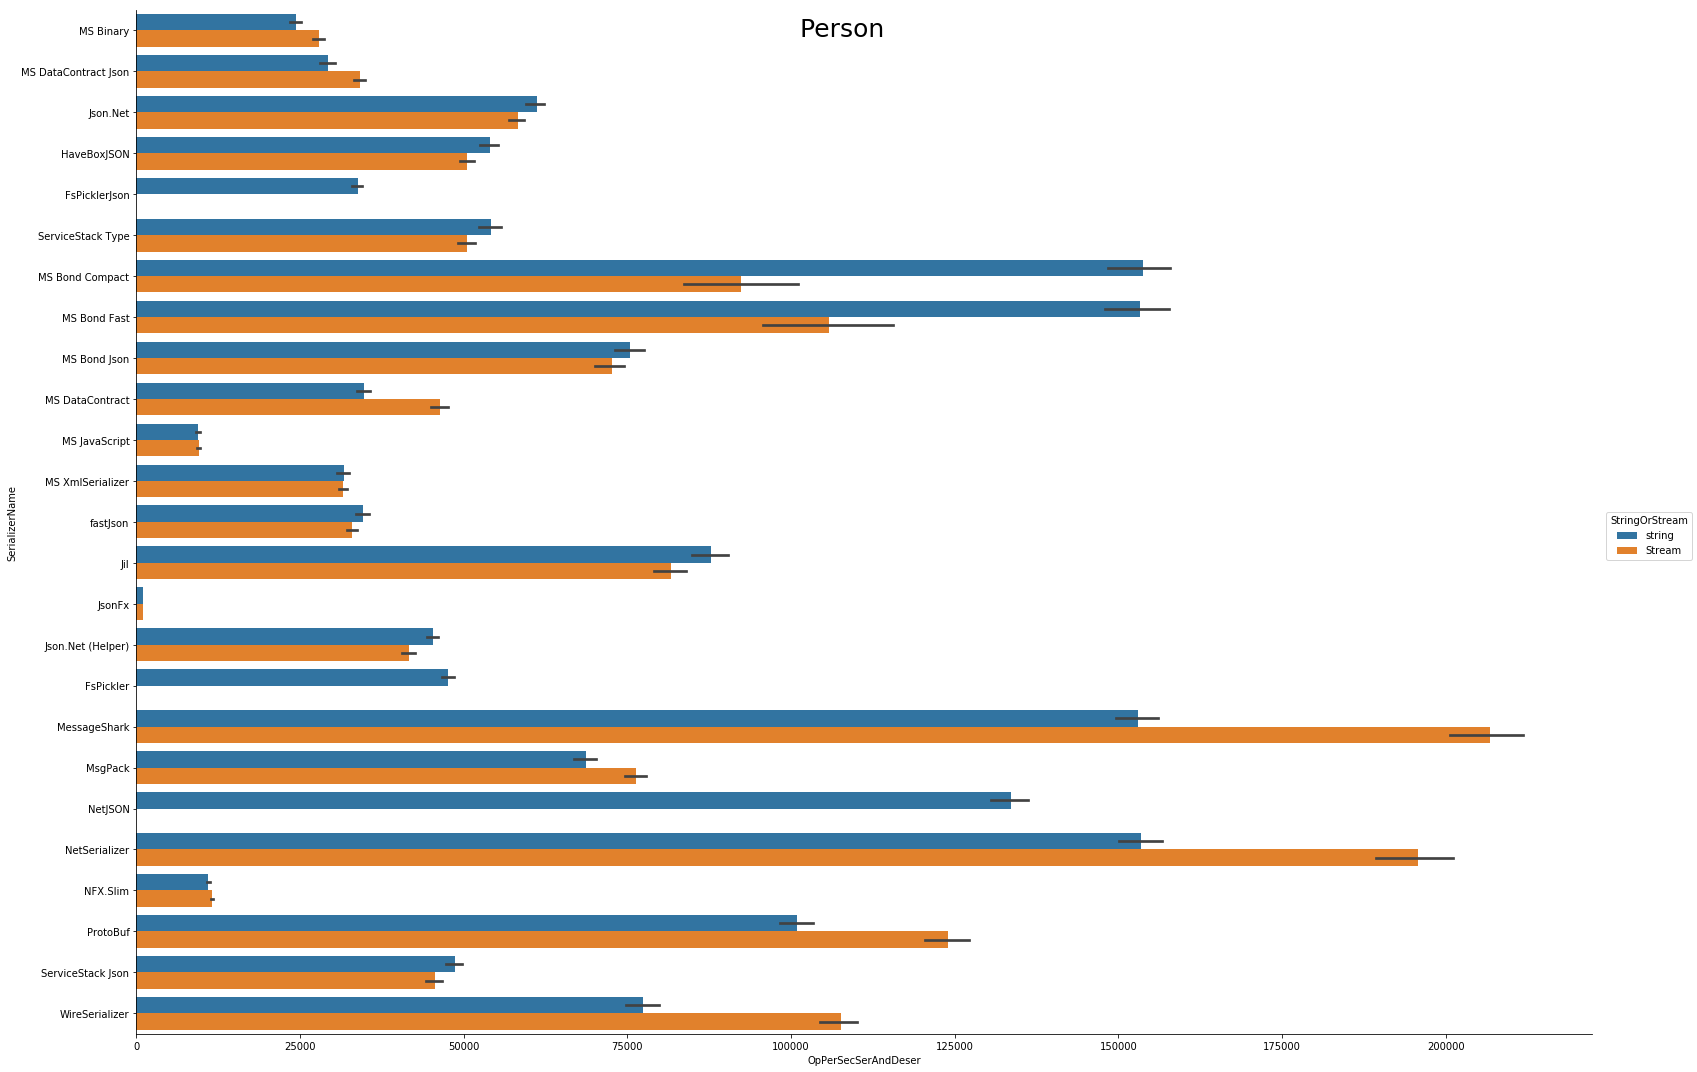

In [136]:
plot_serializers(test_data_names[0])

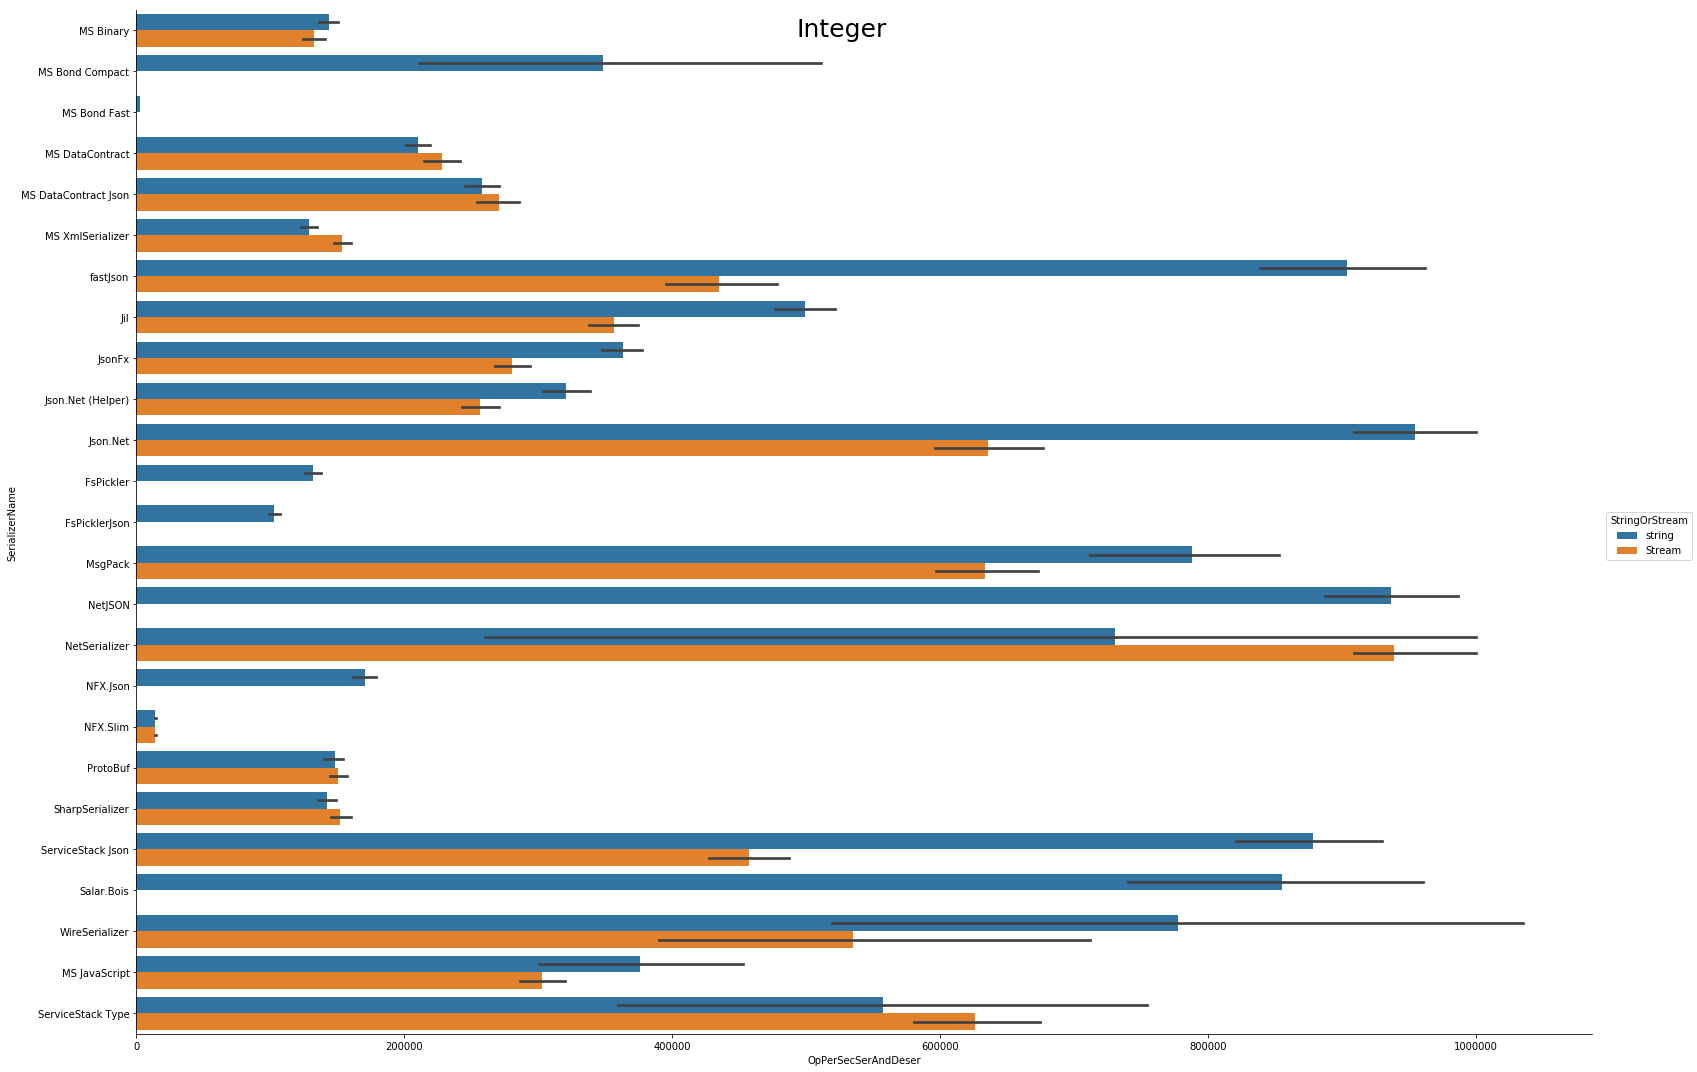

In [112]:
plot_serializers(test_data_names[1])

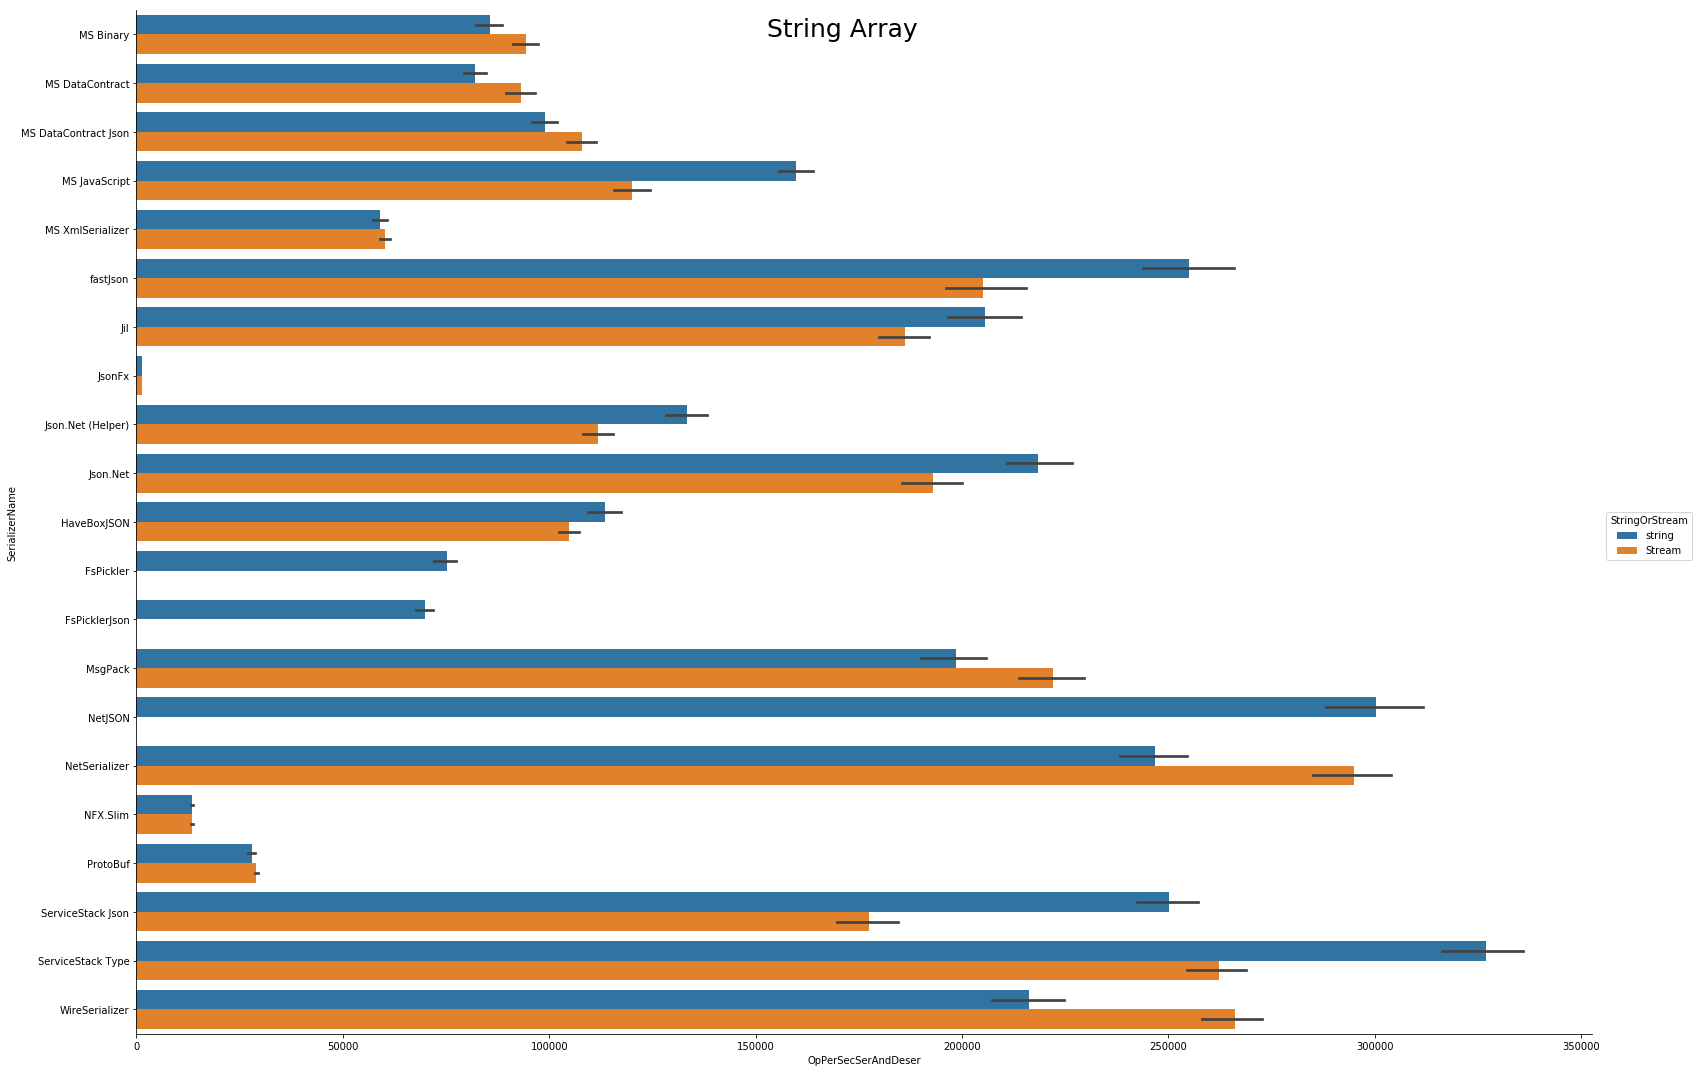

In [113]:
plot_serializers(test_data_names[2])

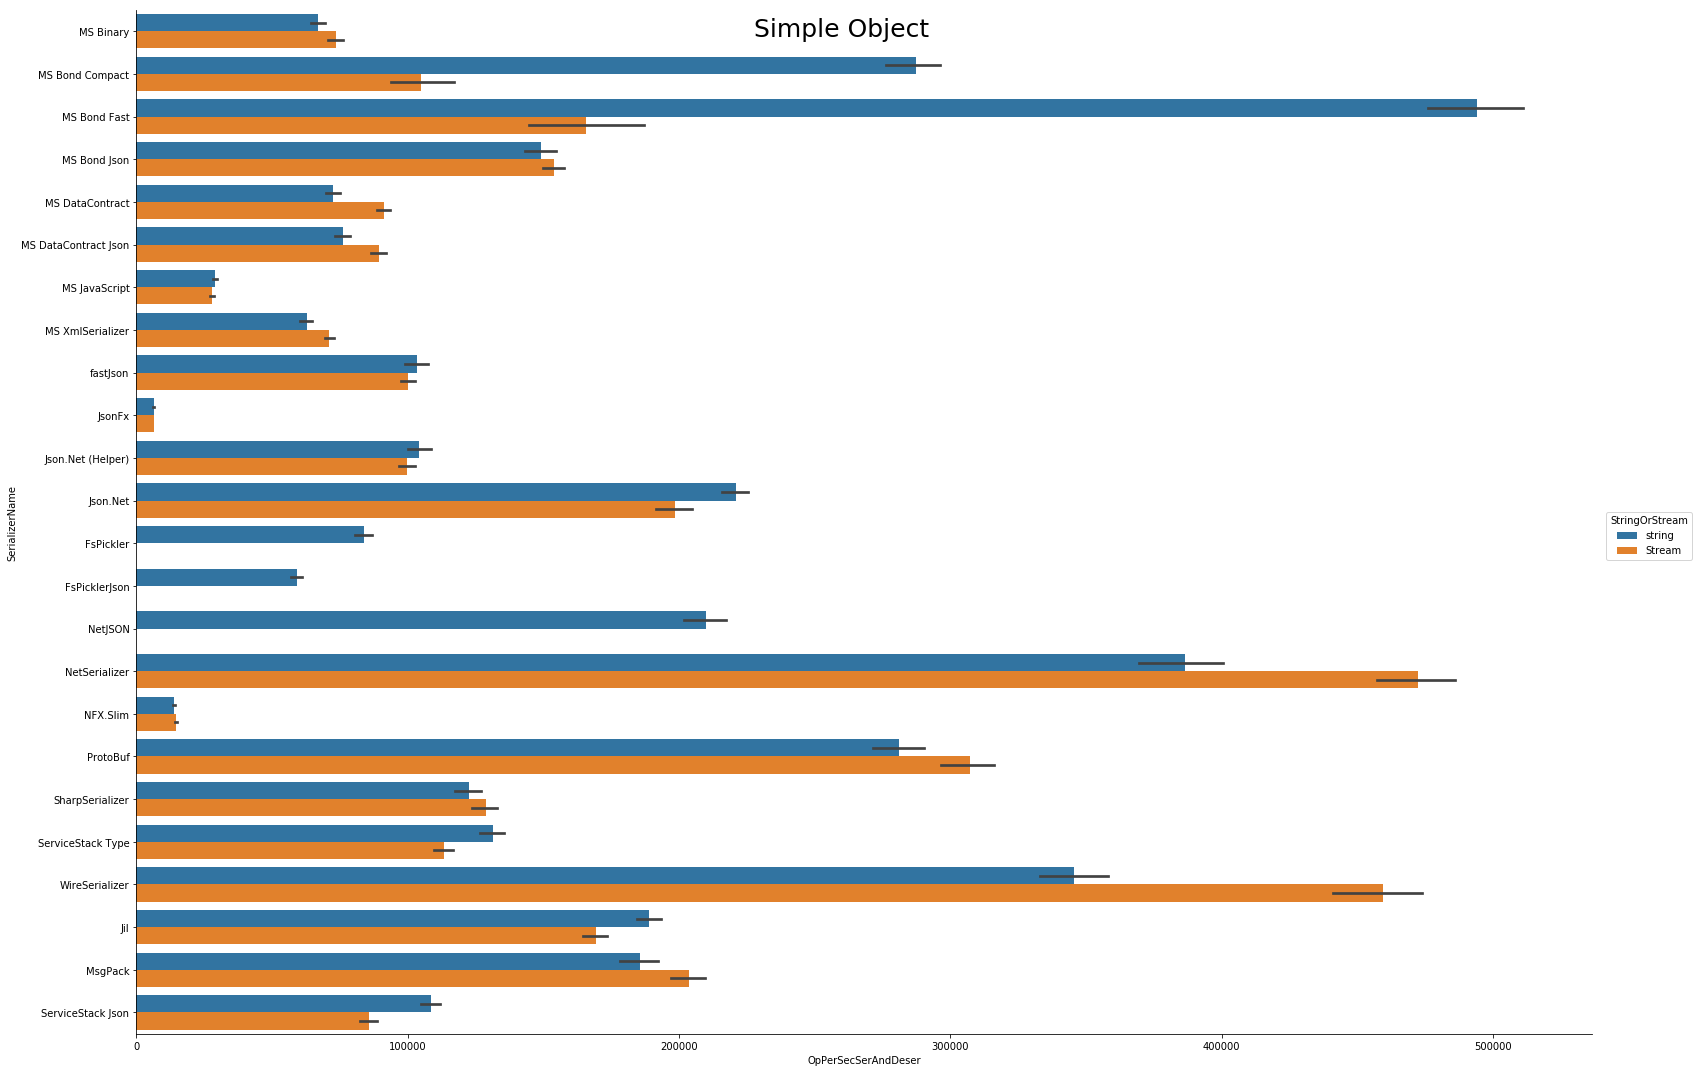

In [114]:
plot_serializers(test_data_names[3])

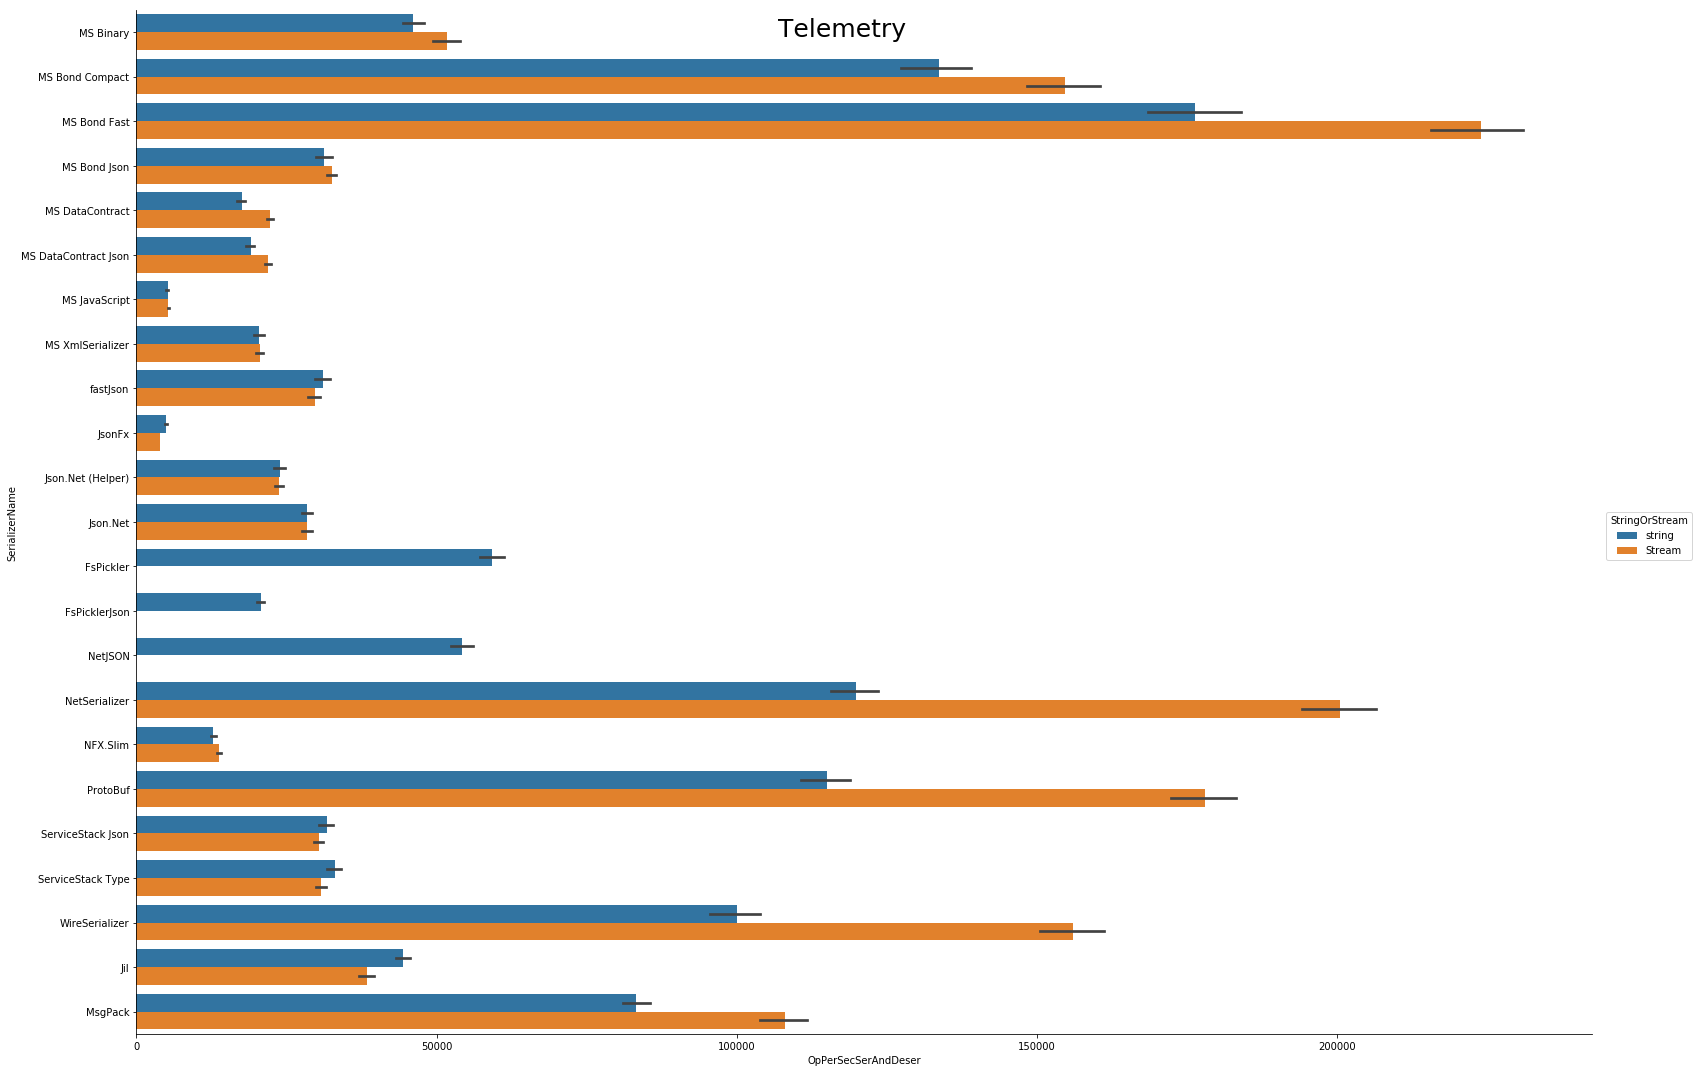

In [115]:
plot_serializers(test_data_names[4])

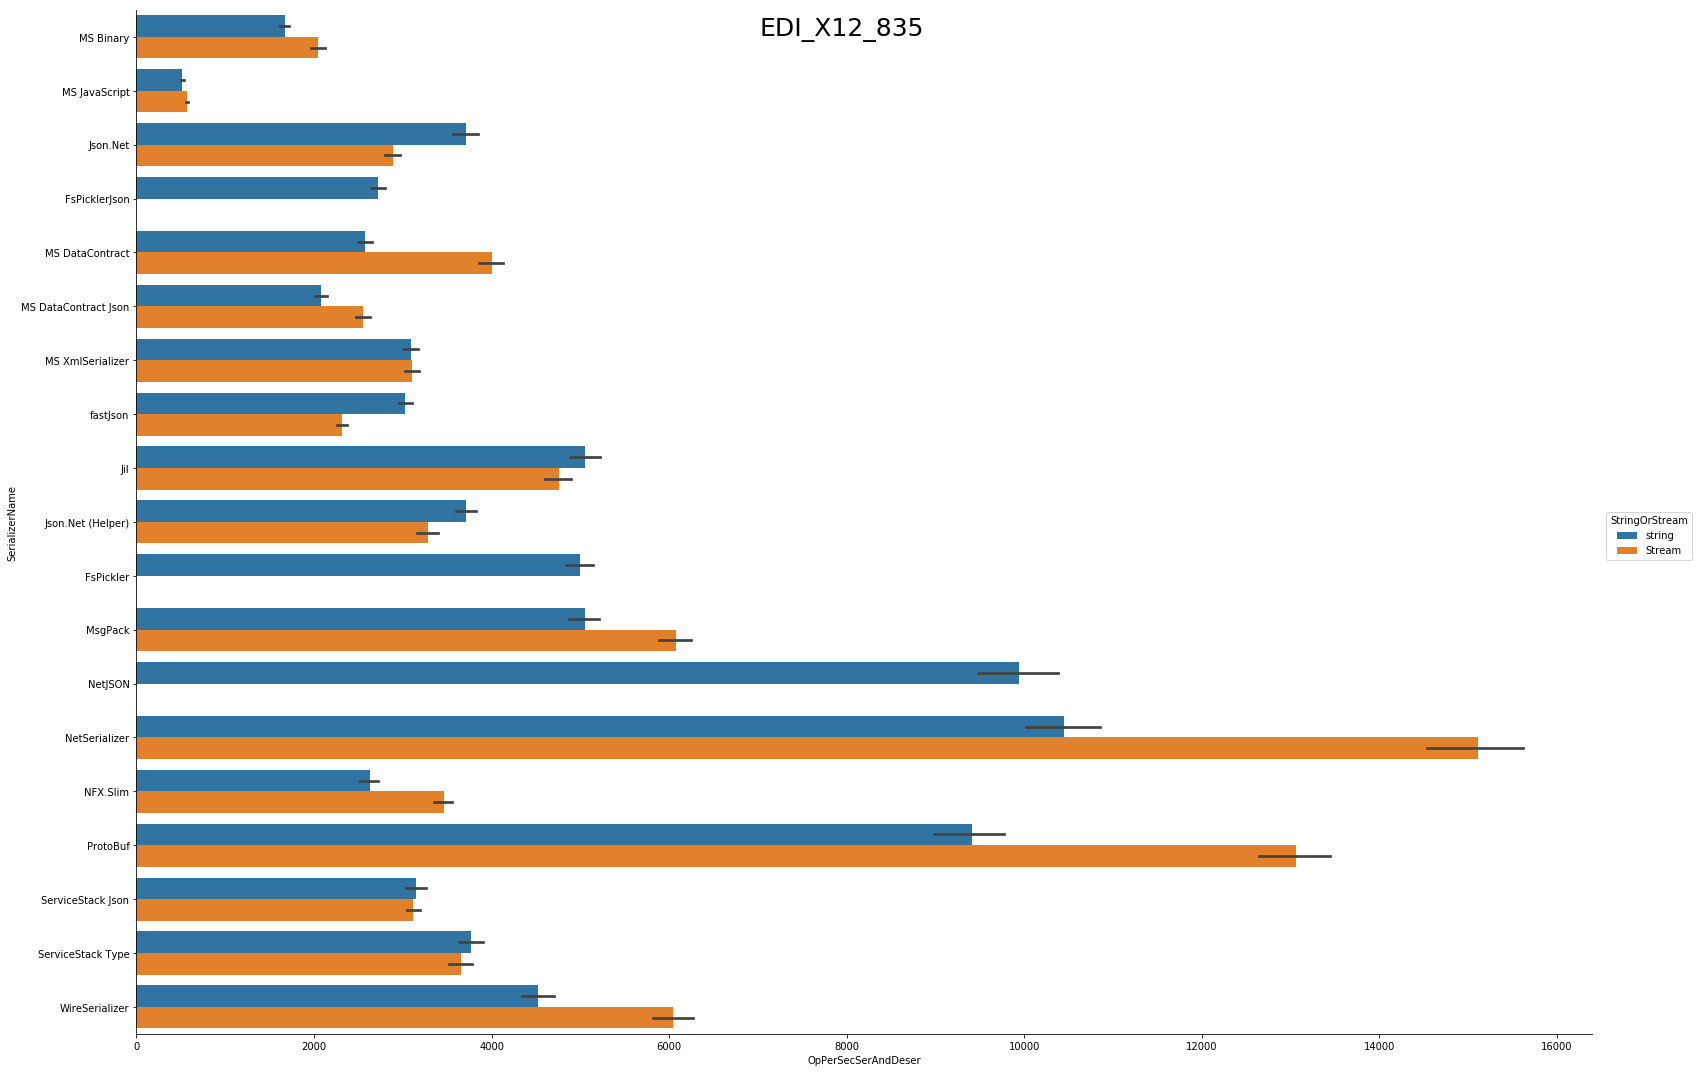

In [116]:
plot_serializers(test_data_names[5])

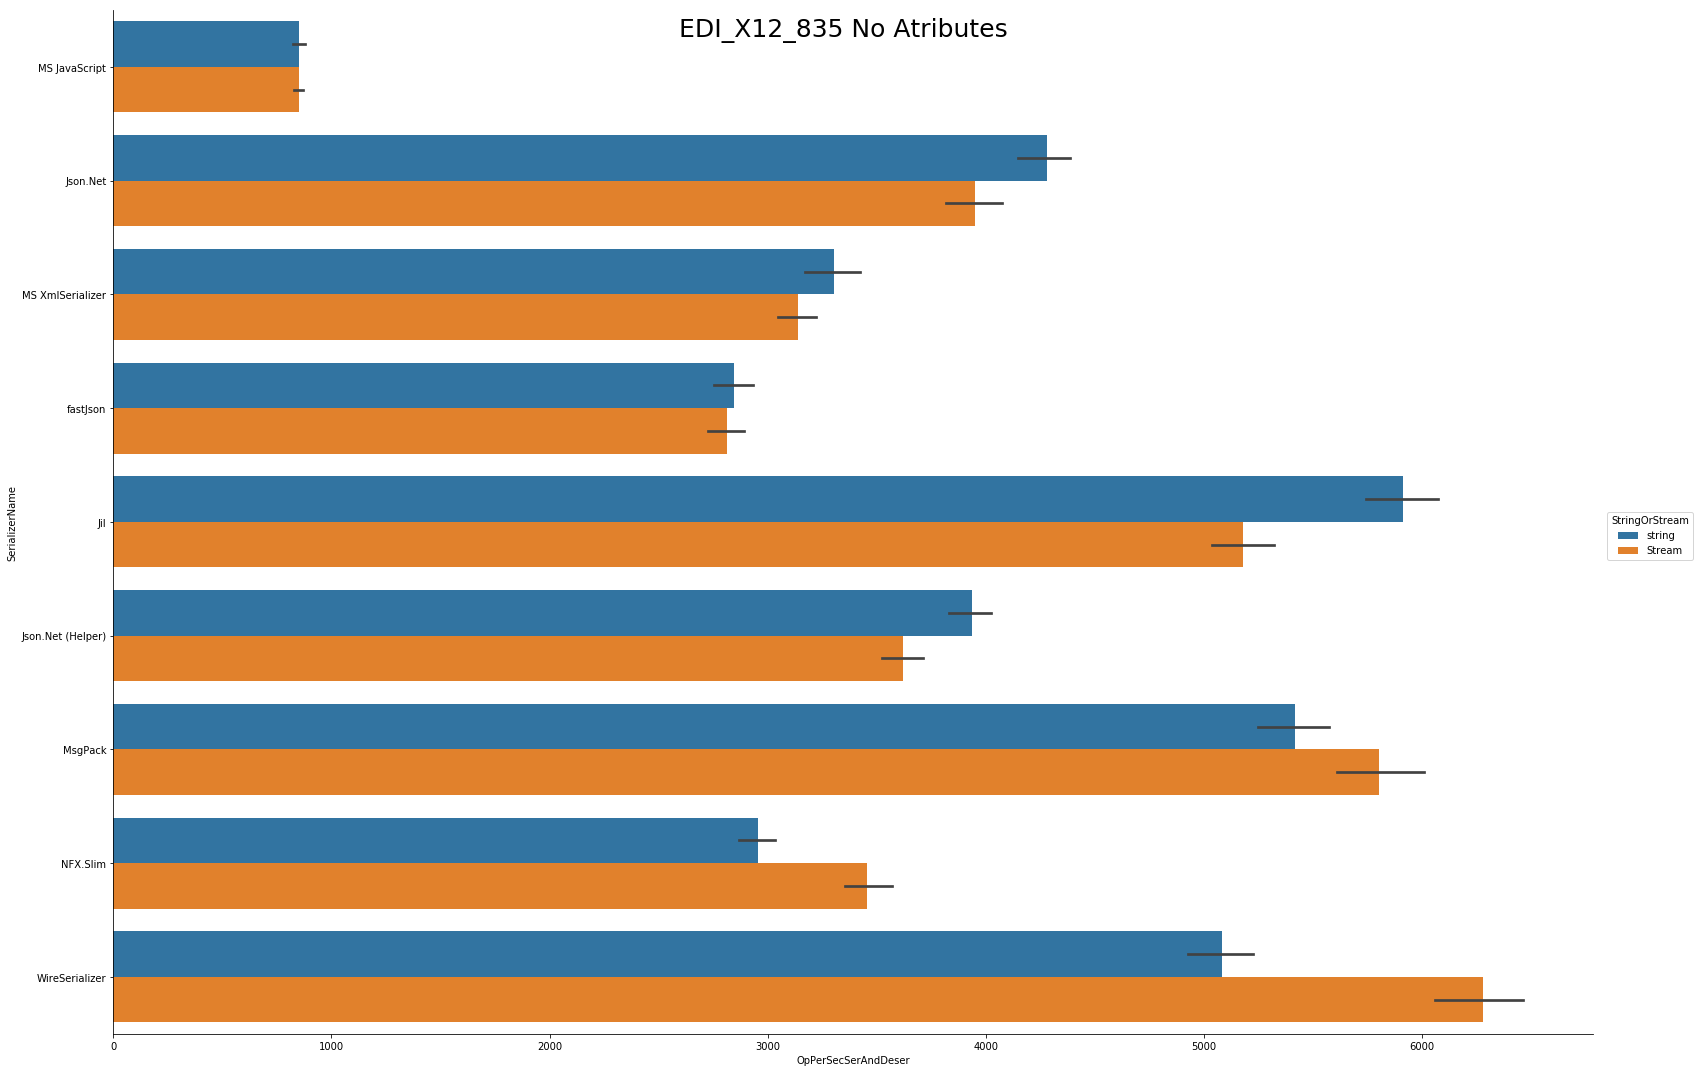

In [117]:
plot_serializers(test_data_names[6])

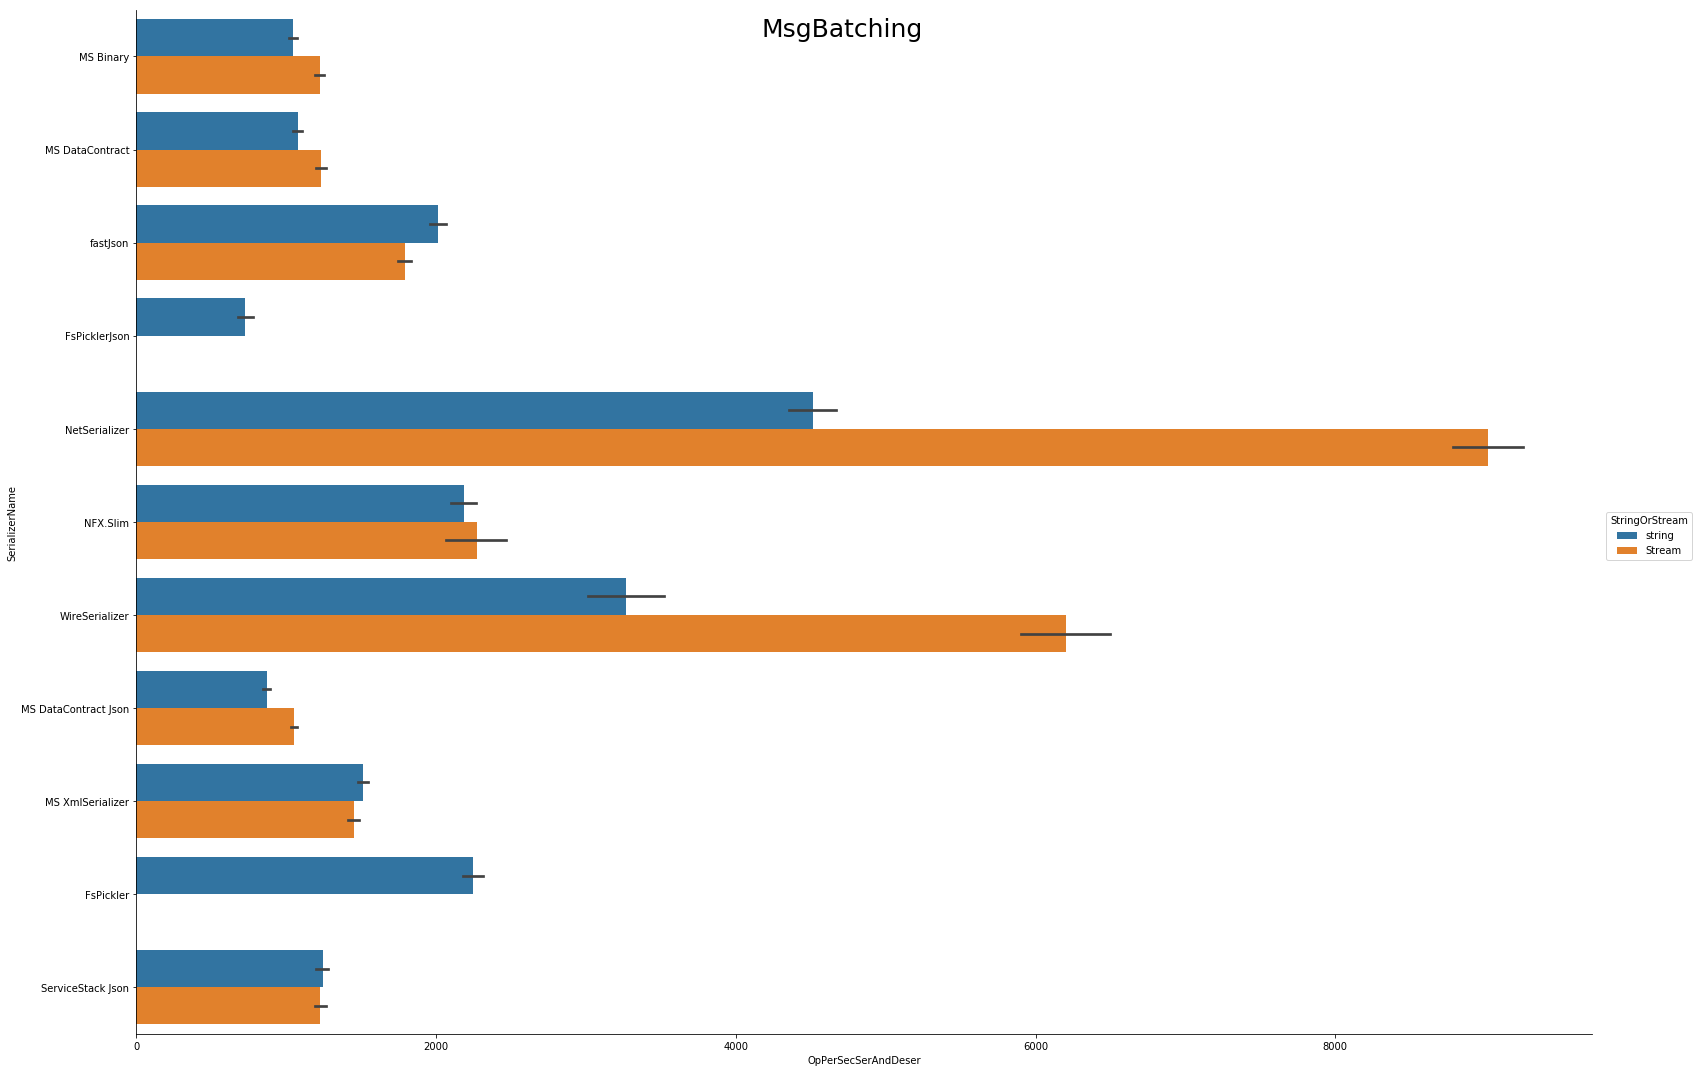

In [118]:
plot_serializers(test_data_names[7])

### More Statistical Information in Plots
Let's change the standard histograms to the box plots. Here we can see the distribution of the values.

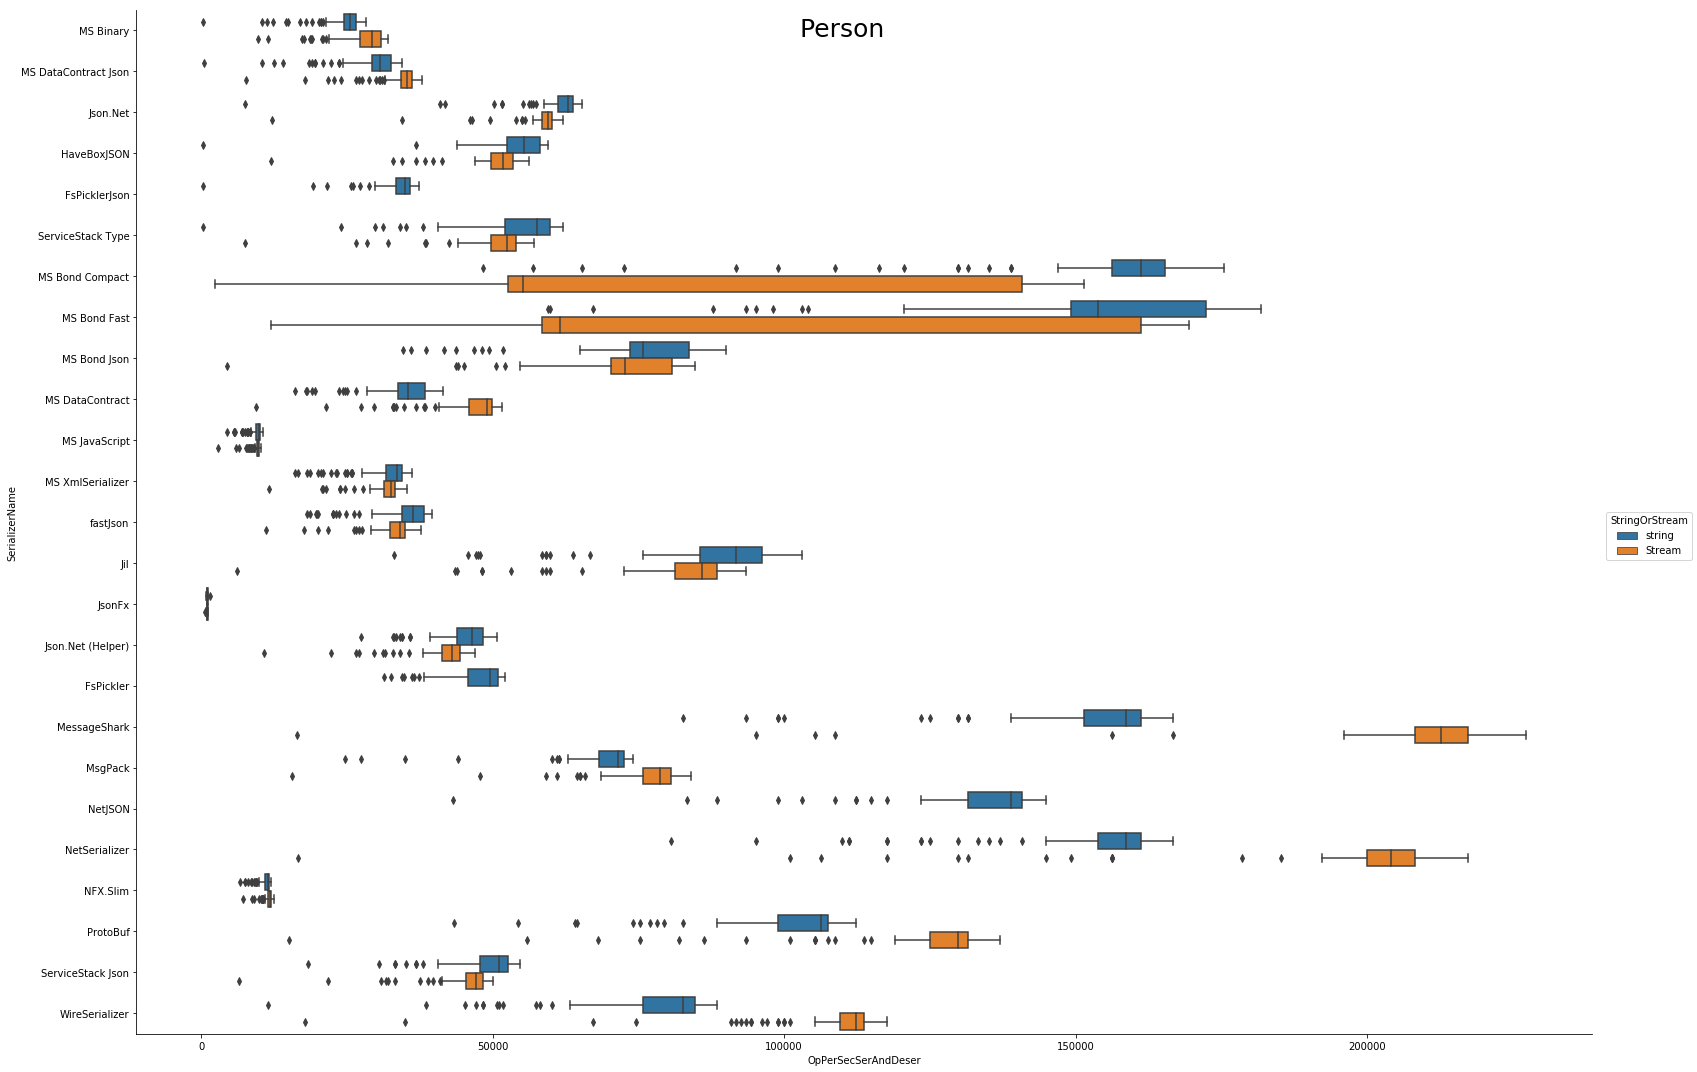

In [137]:
def plot_serializers2(test_data_name):
    x_td = x[x.TestDataName == test_data_name]
    ax = sns.factorplot(x="OpPerSecSerAndDeser", y="SerializerName", hue="StringOrStream", 
                        data=x_td, kind="box", size=15, aspect=1.5)
    _ = ax.fig.suptitle(test_data_name, fontsize=25)
    
plot_serializers2(test_data_names[0])

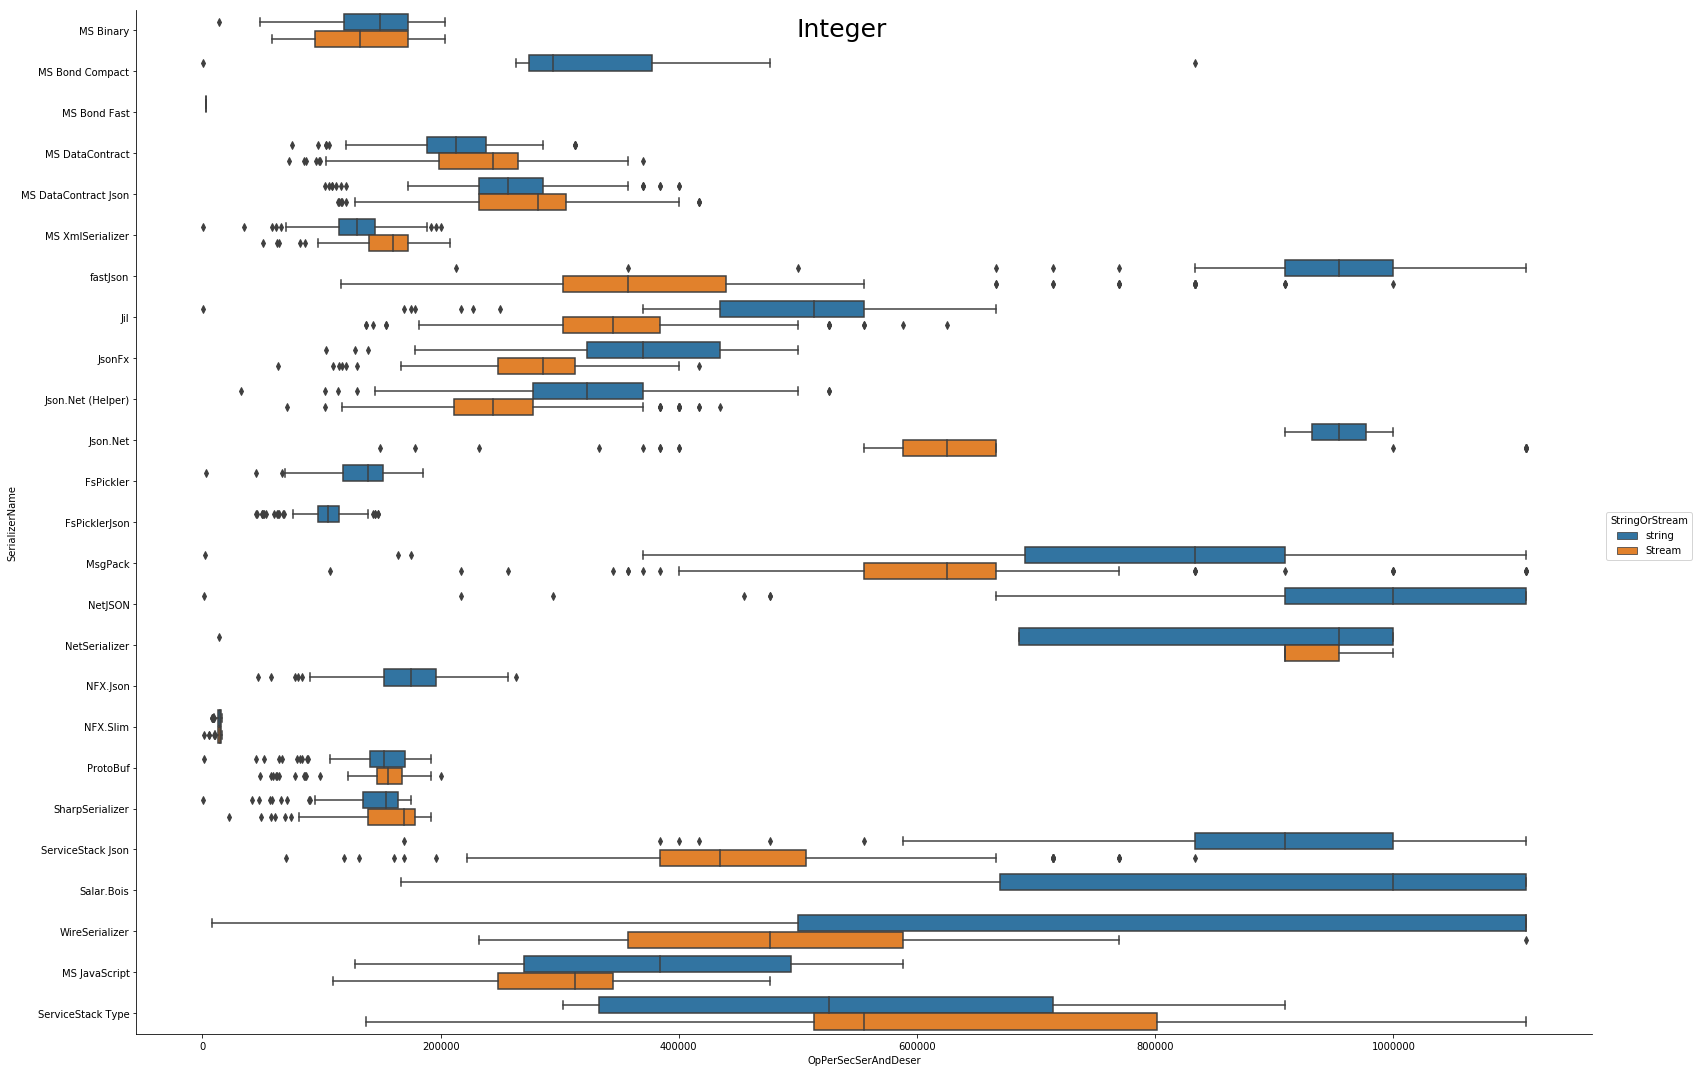

In [138]:
plot_serializers2(test_data_names[1])

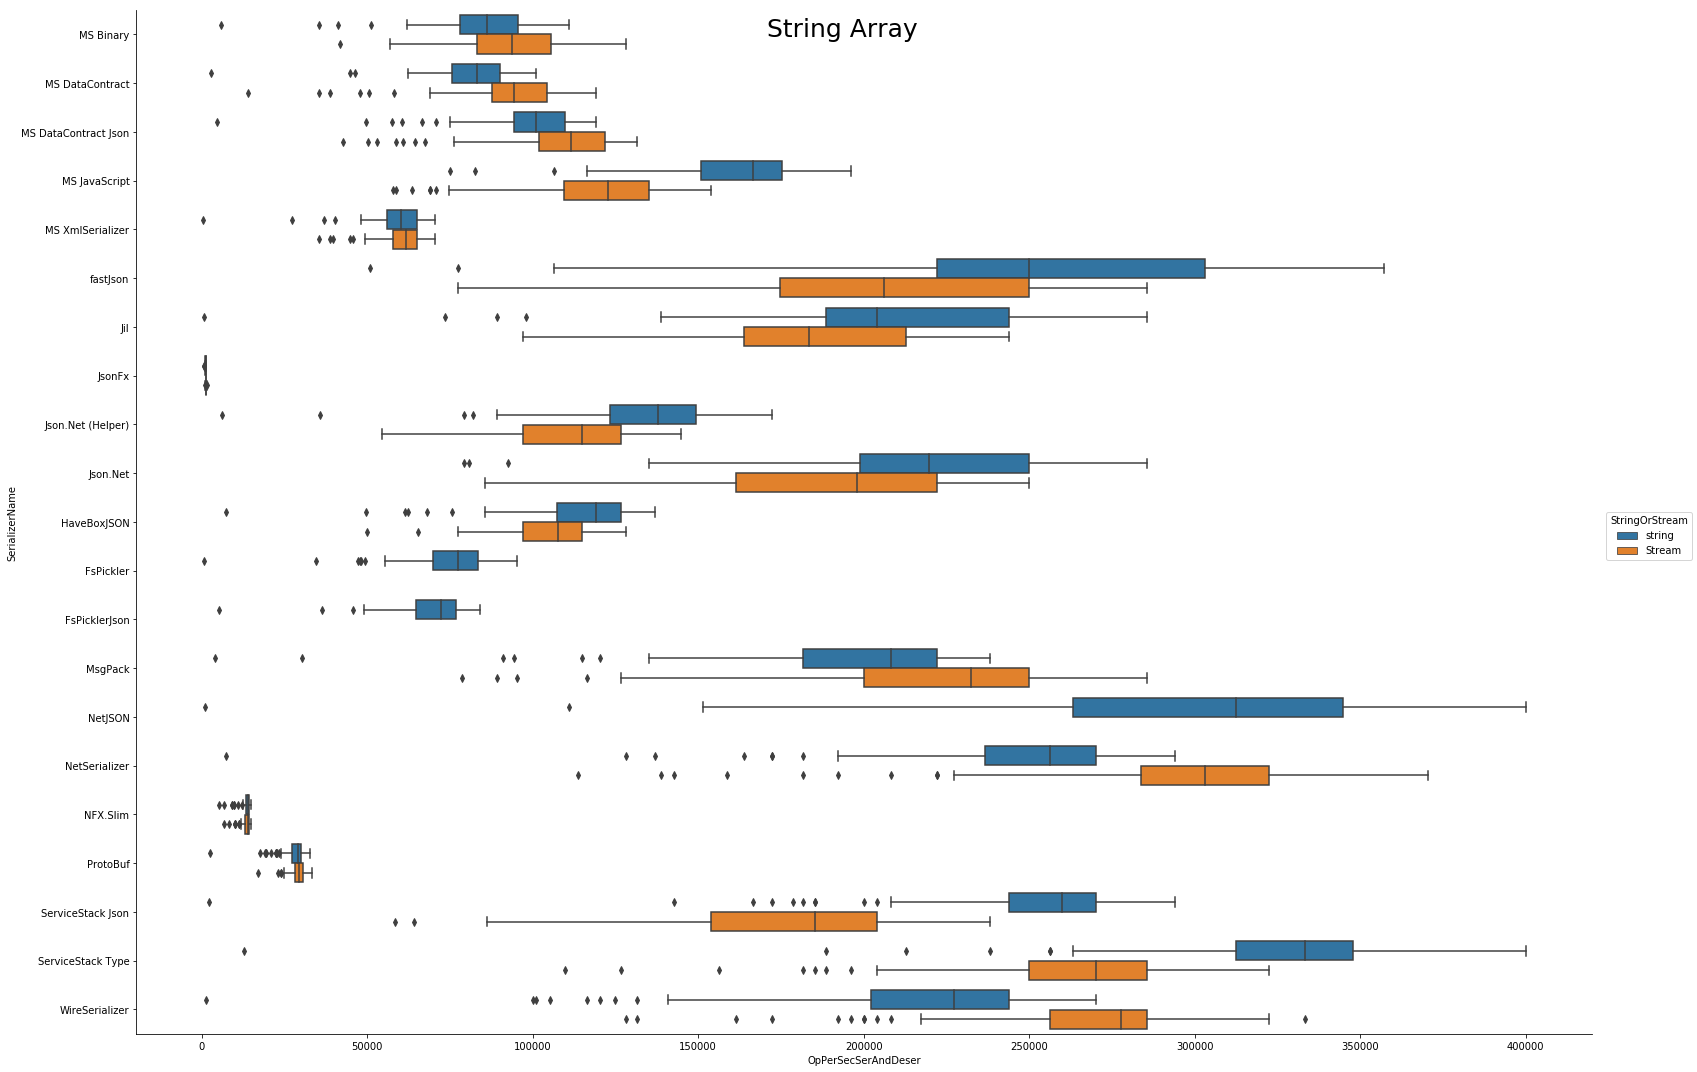

In [122]:
plot_serializers2(test_data_names[2])

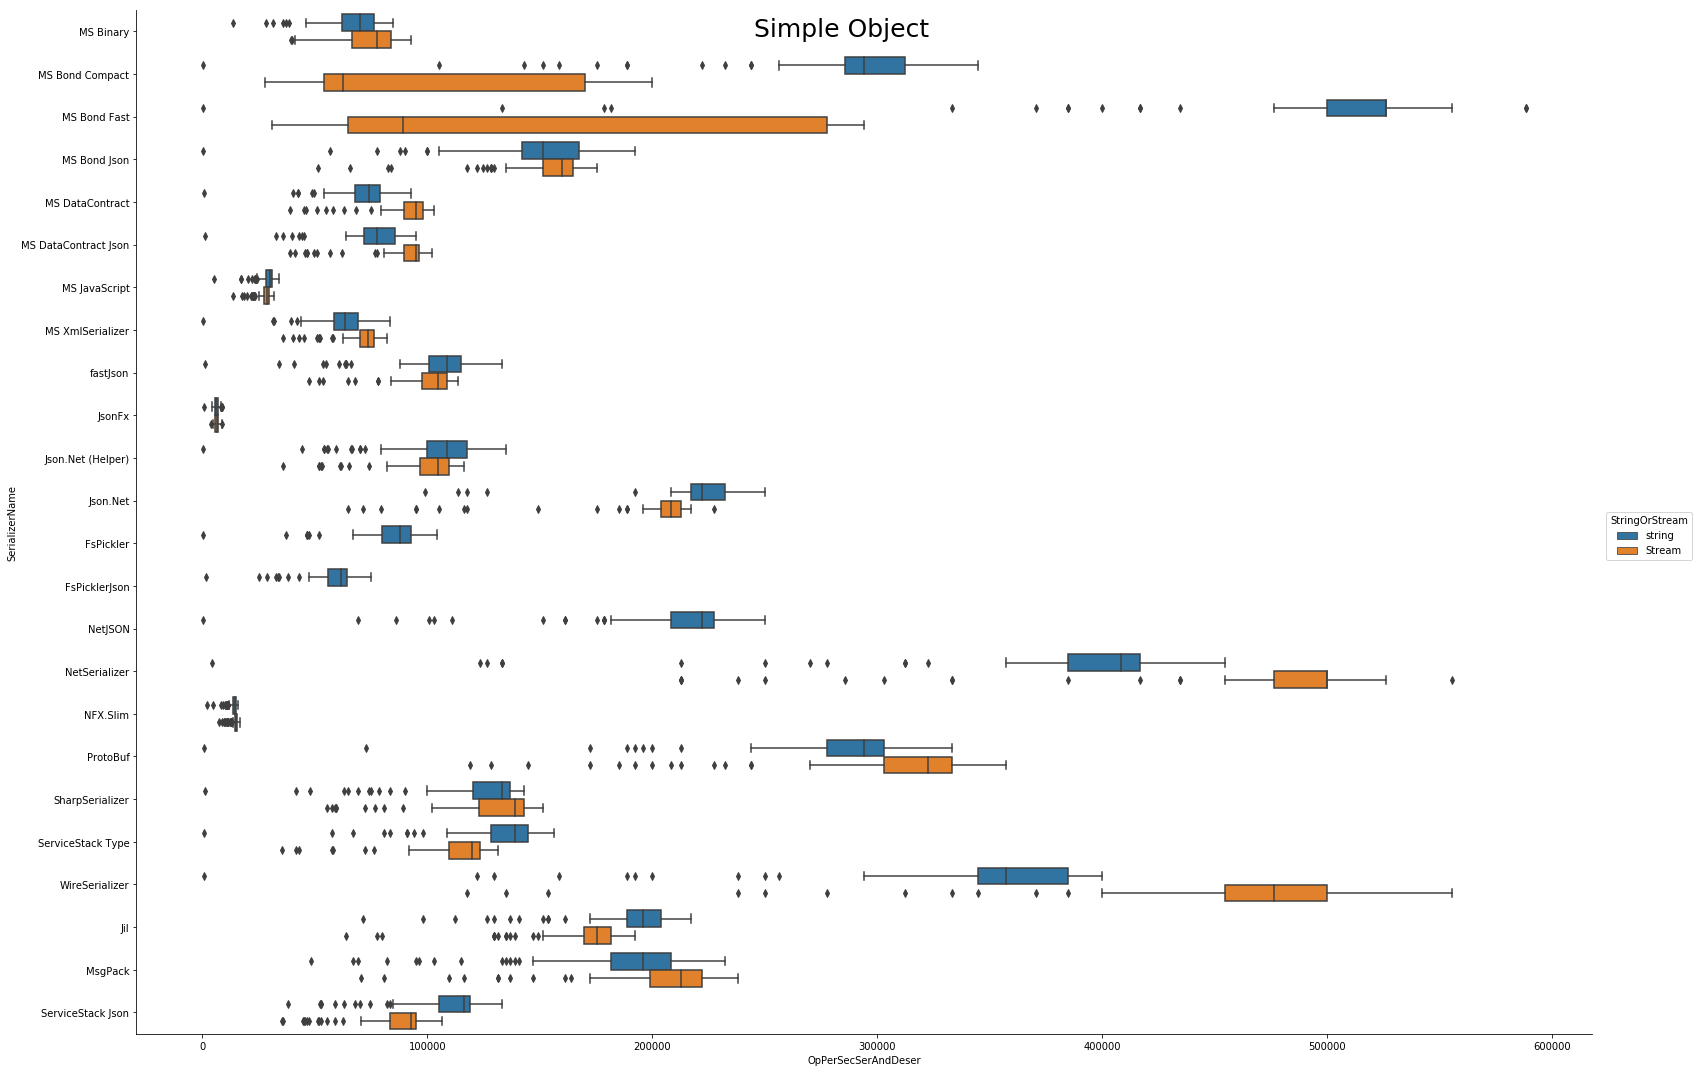

In [123]:
plot_serializers2(test_data_names[3])

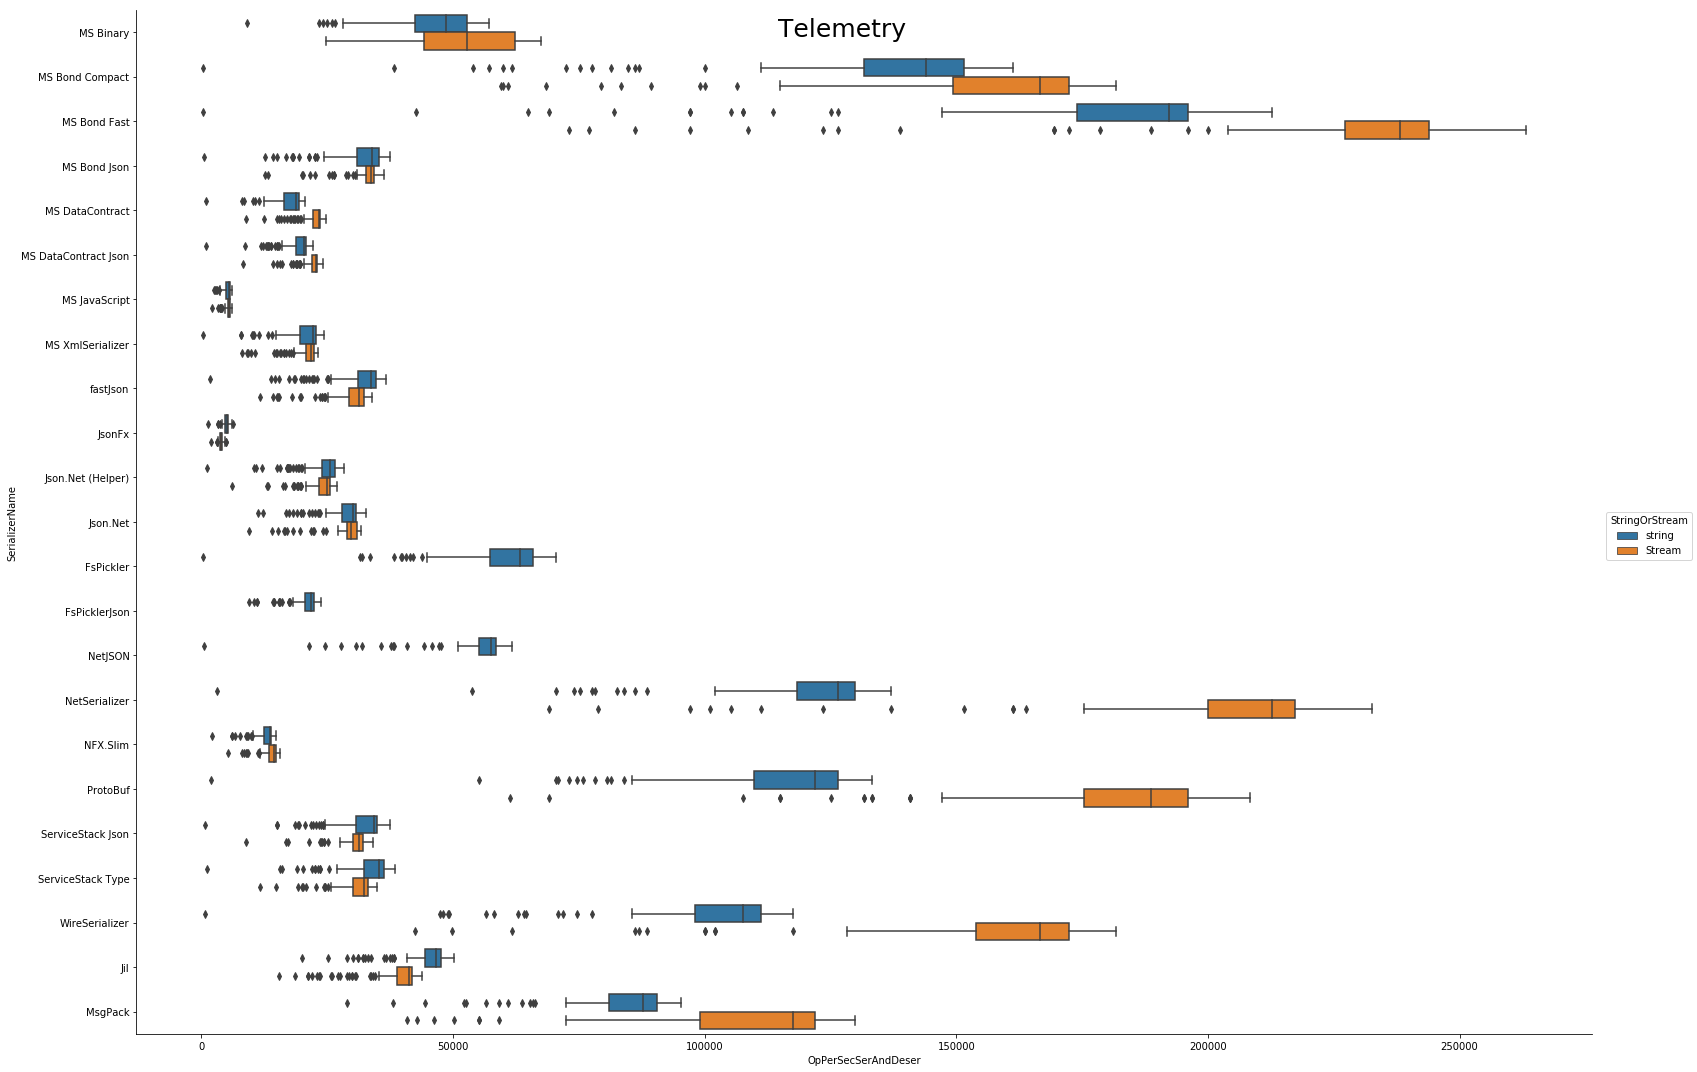

In [124]:
plot_serializers2(test_data_names[4])

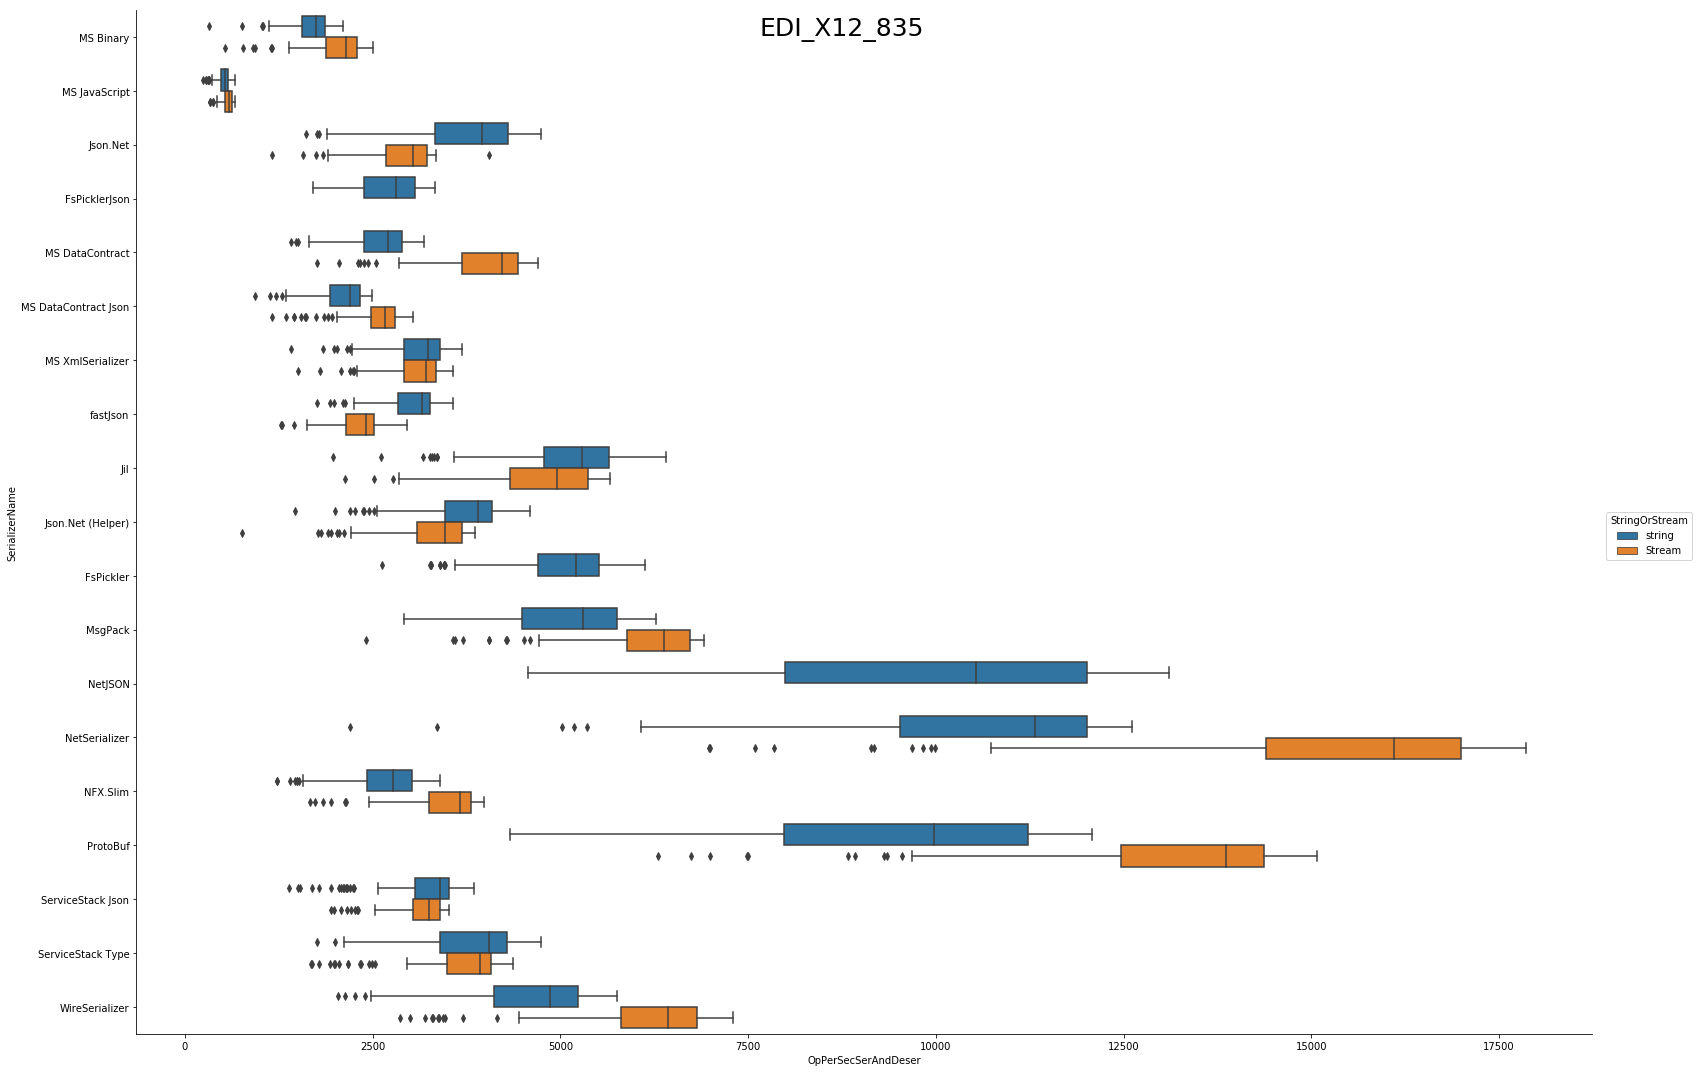

In [125]:
plot_serializers2(test_data_names[5])

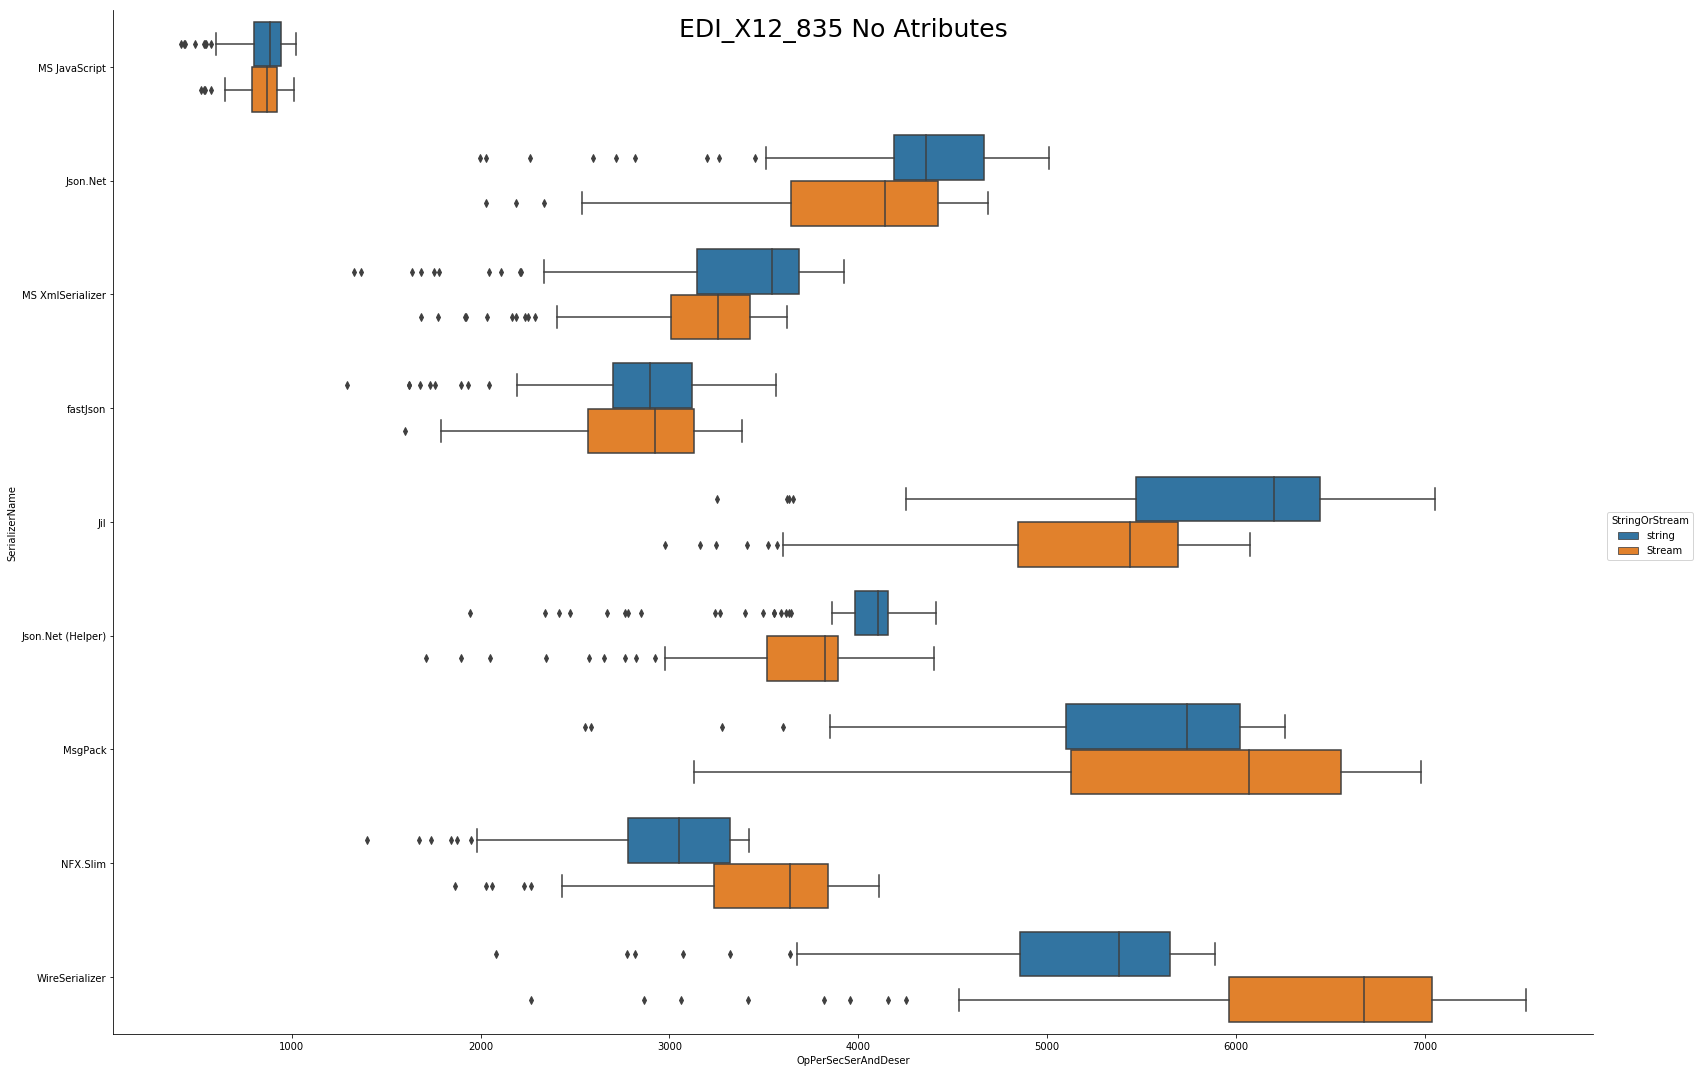

In [126]:
plot_serializers2(test_data_names[6])

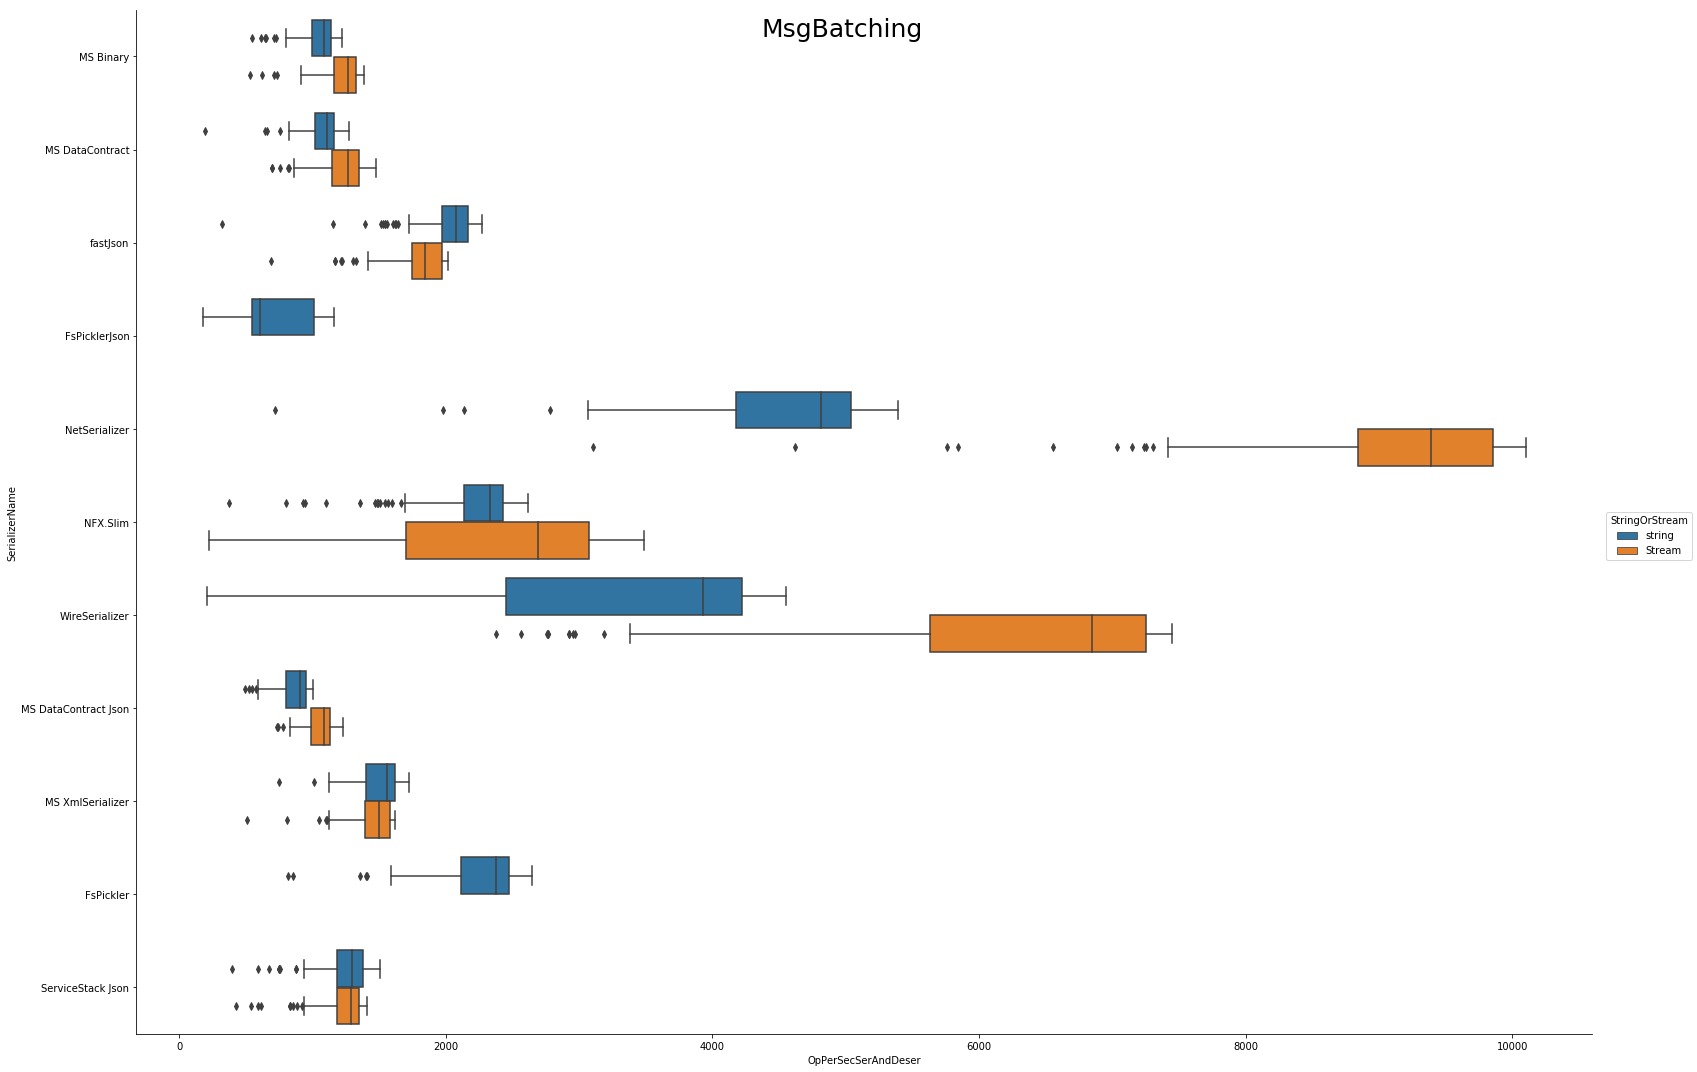

In [127]:
plot_serializers2(test_data_names[7])

## Conclusions:
- **string** and **Stream** mode performance can vary in wide limits.
- Some serializers perform better in the stream mode, some perform better in the string mode. Theory, that Stream is always faster, is wrong.

# Compare Serializers for the Different Data Types for the Serialize and Deserialize Operations for the Streams
Now we only consider the Stream mode but analyze the data comparing the serialization and deserialization measurements separatly.

In [147]:
print(df.shape)
x = df[df.StringOrStream == 'Stream']
x = clean_up_outliers(x)

(29400, 12)
(13500, 12)
(13208, 12)
(13007, 12)


In [152]:
x1 = x.copy()
x1['Operation'] = 'Serialize'
x1['OpPerSec'] = x1.OpPerSecSer
x2 = x.copy()
x2['Operation'] = 'Deserialize'
x2['OpPerSec'] = x2.OpPerSecDeser
x_sd = pd.concat([x1, x2], axis=0)
print(x1.shape, x2.shape, x_sd.shape)
#x_sd.head(10)


(13007, 14) (13007, 14) (26014, 14)


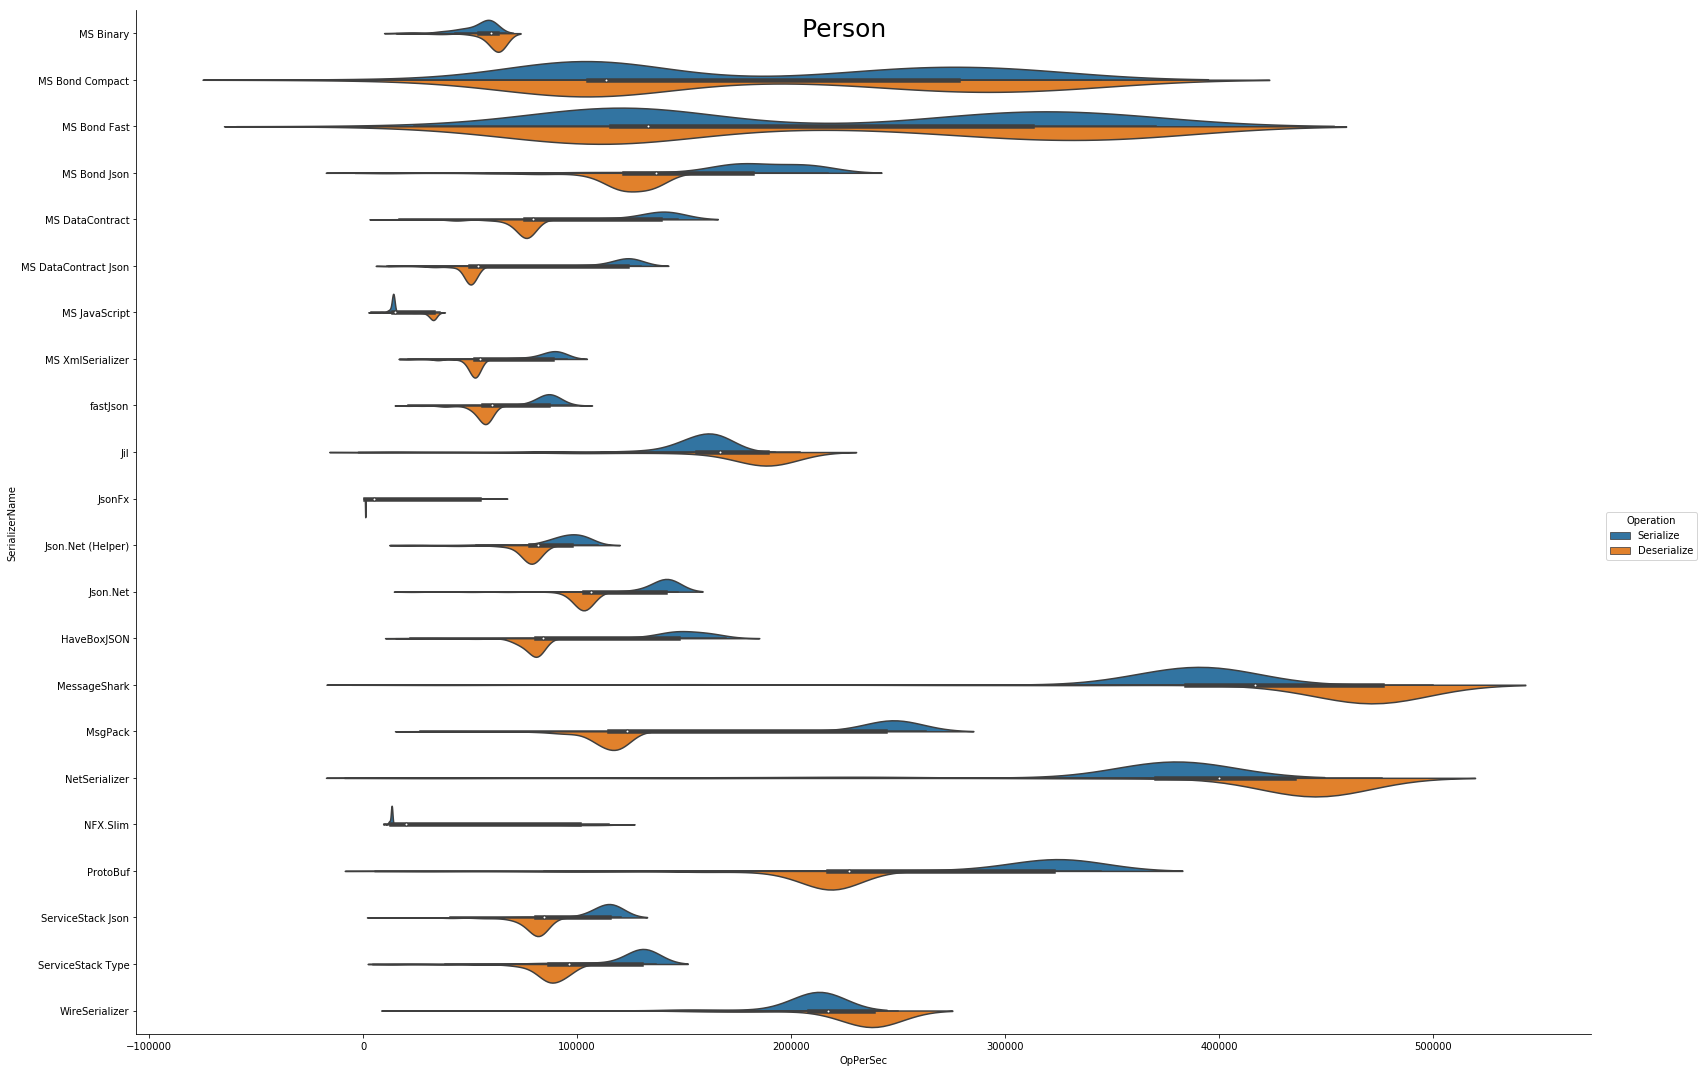

In [156]:
def plot_serializers3(test_data_name):
    x_td = x_sd[x_sd.TestDataName == test_data_name]
    ax = sns.factorplot(x="OpPerSec", y="SerializerName", hue="Operation", 
                        data=x_td, kind="violin", split=True, size=15, aspect=1.5)
    _ = ax.fig.suptitle(test_data_name, fontsize=25)
    
plot_serializers3(test_data_names[0])

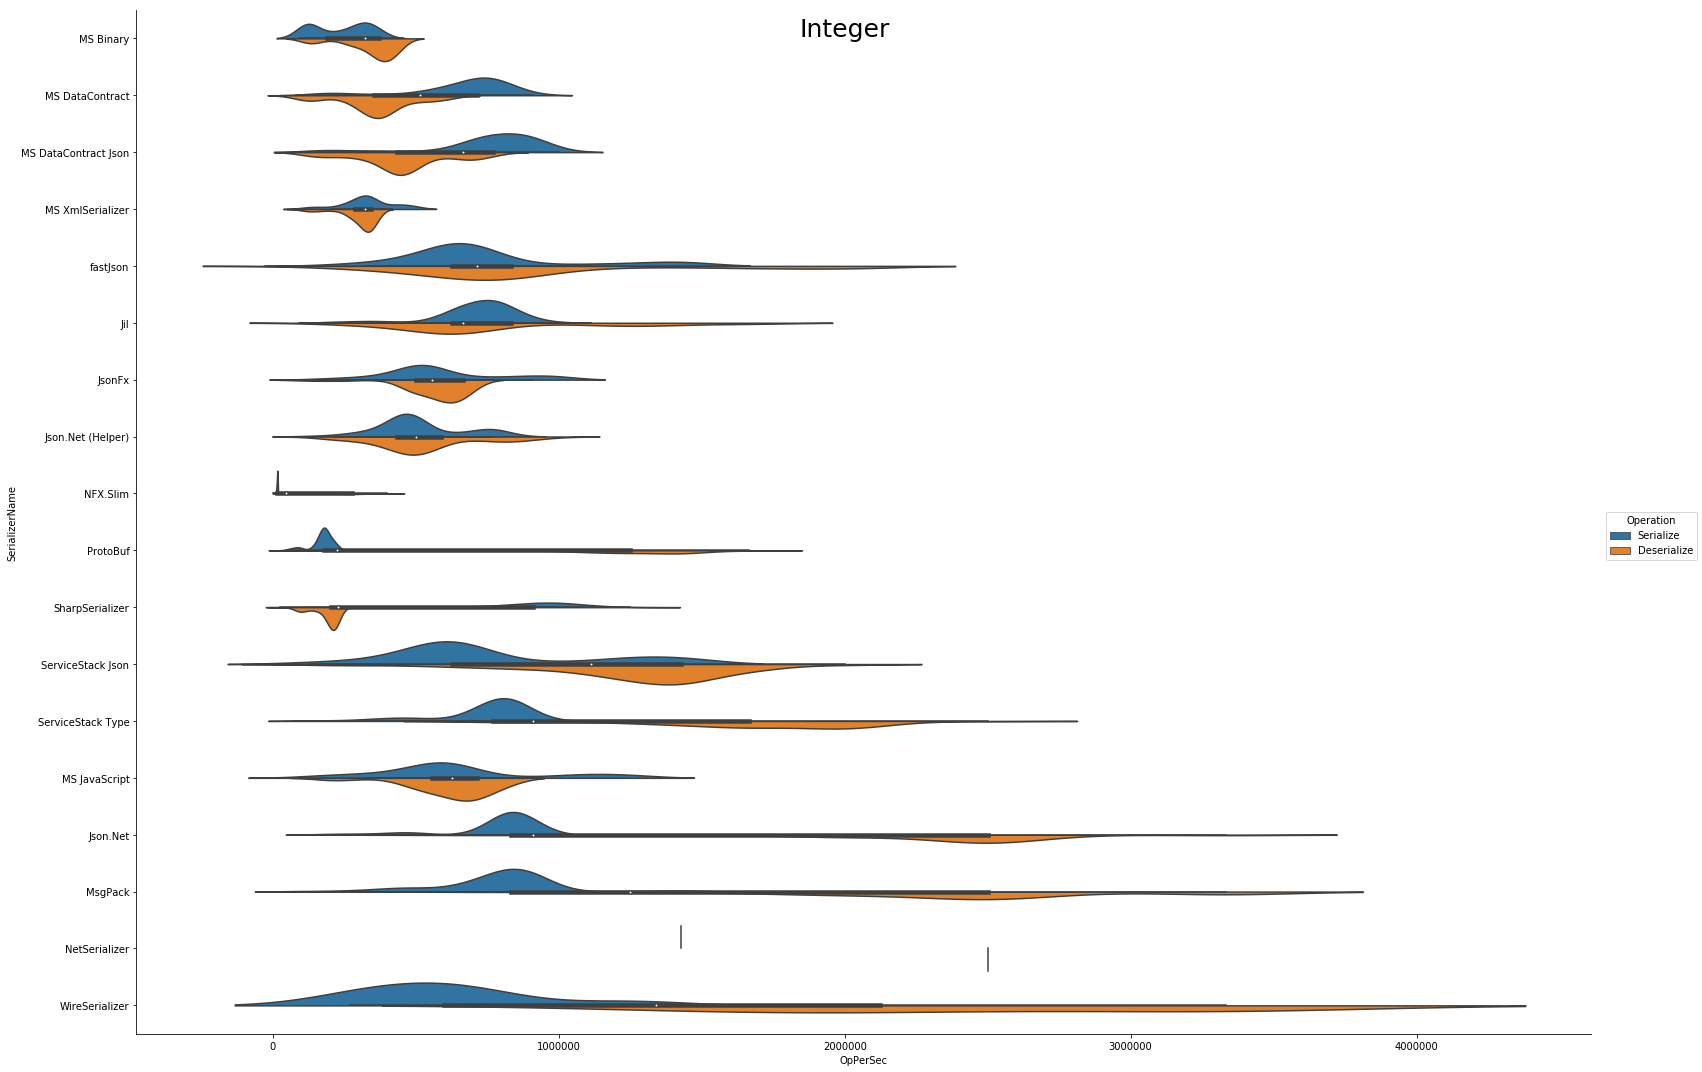

In [157]:
plot_serializers3(test_data_names[1])

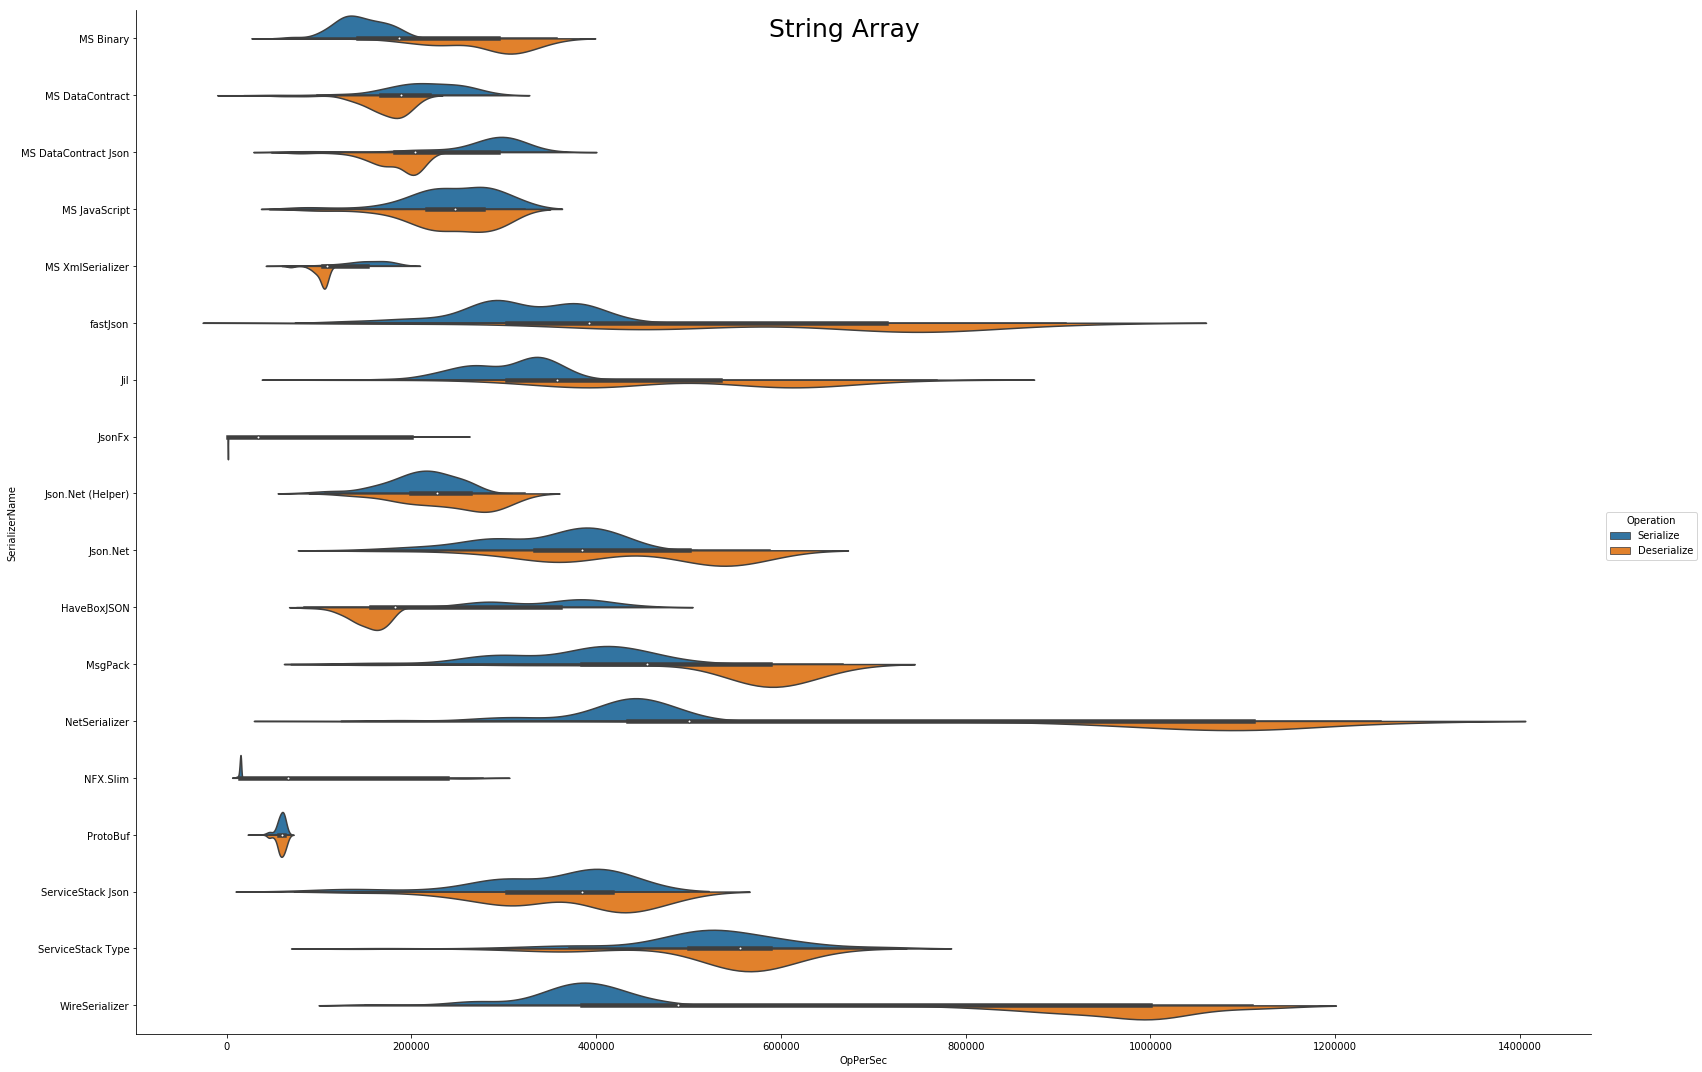

In [158]:
plot_serializers3(test_data_names[2])

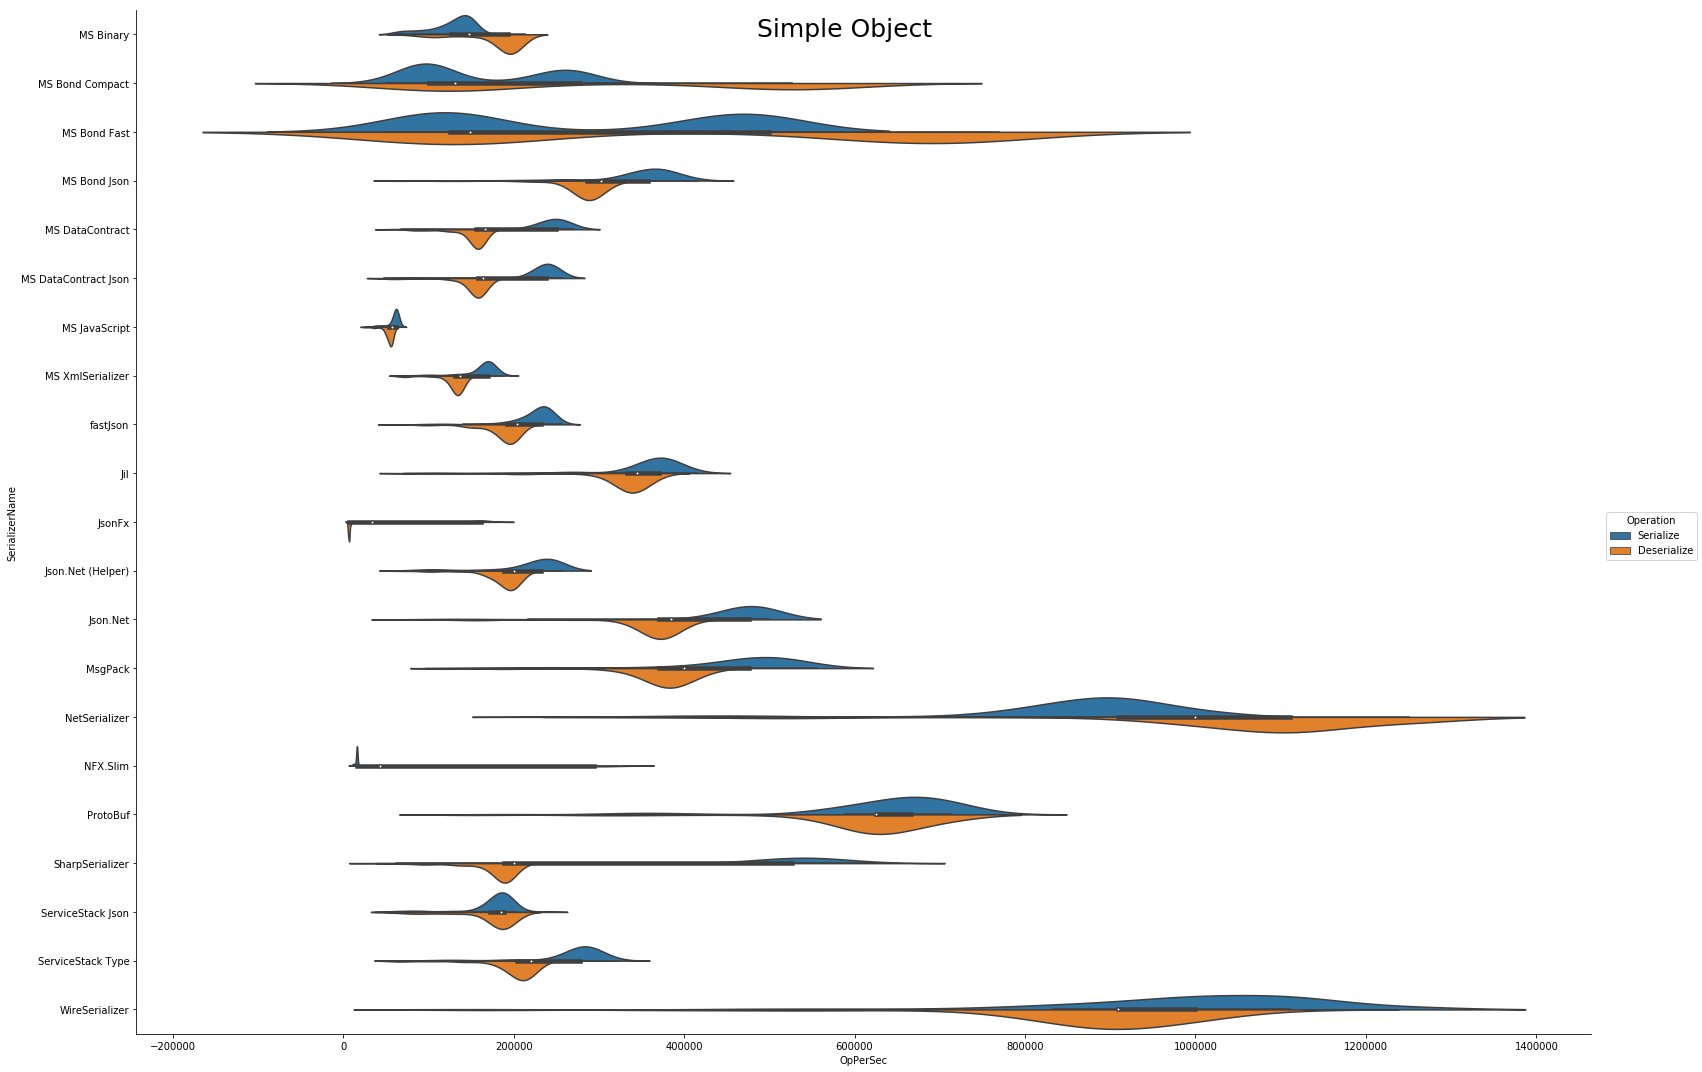

In [159]:
plot_serializers3(test_data_names[3])

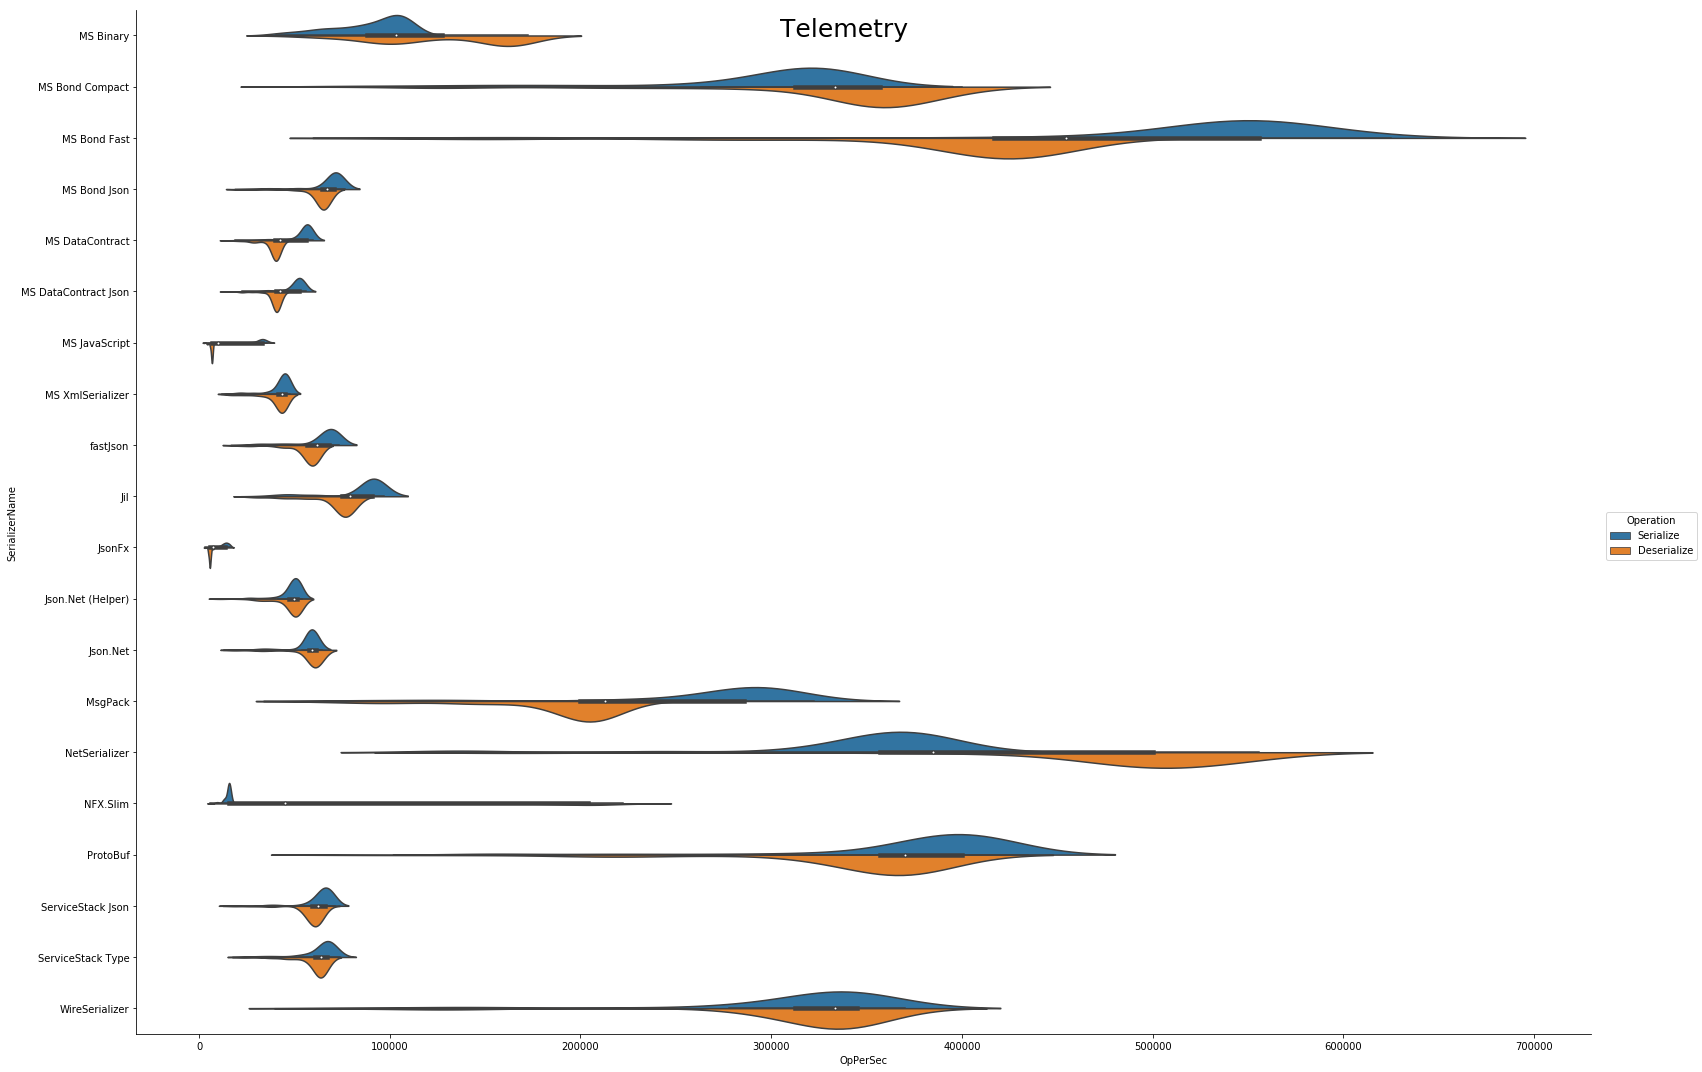

In [160]:
plot_serializers3(test_data_names[4])

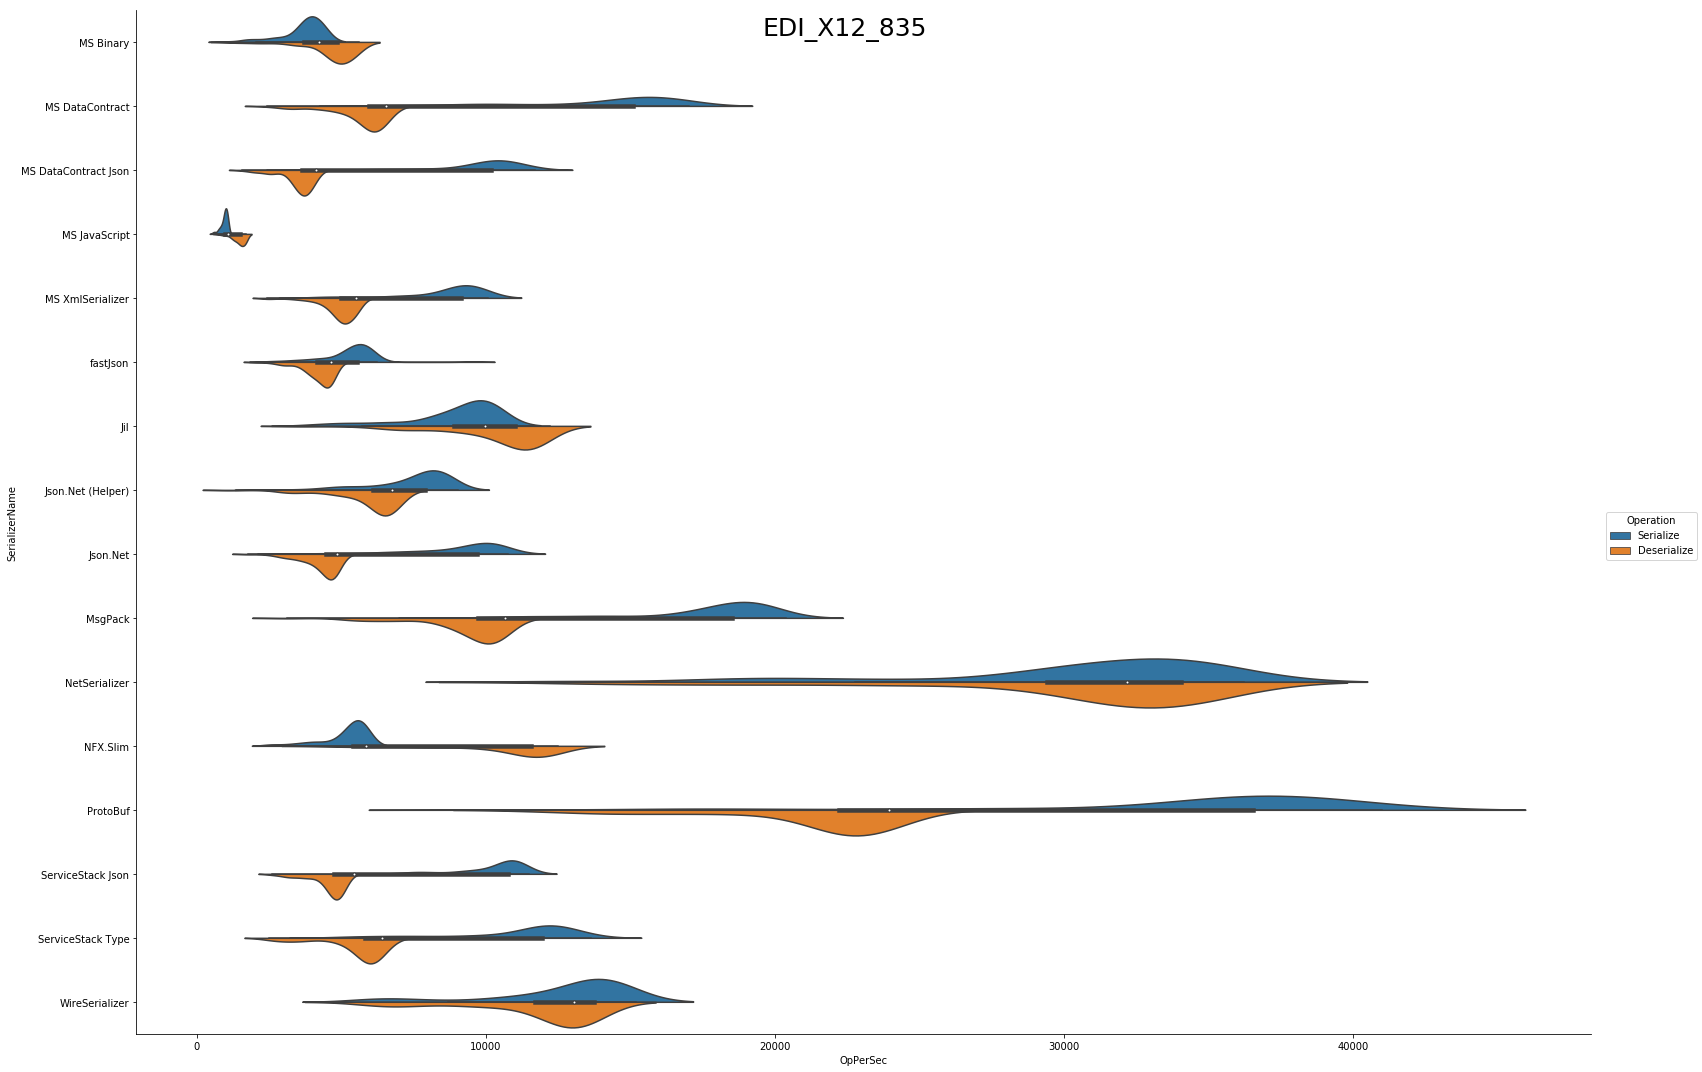

In [161]:
plot_serializers3(test_data_names[5])

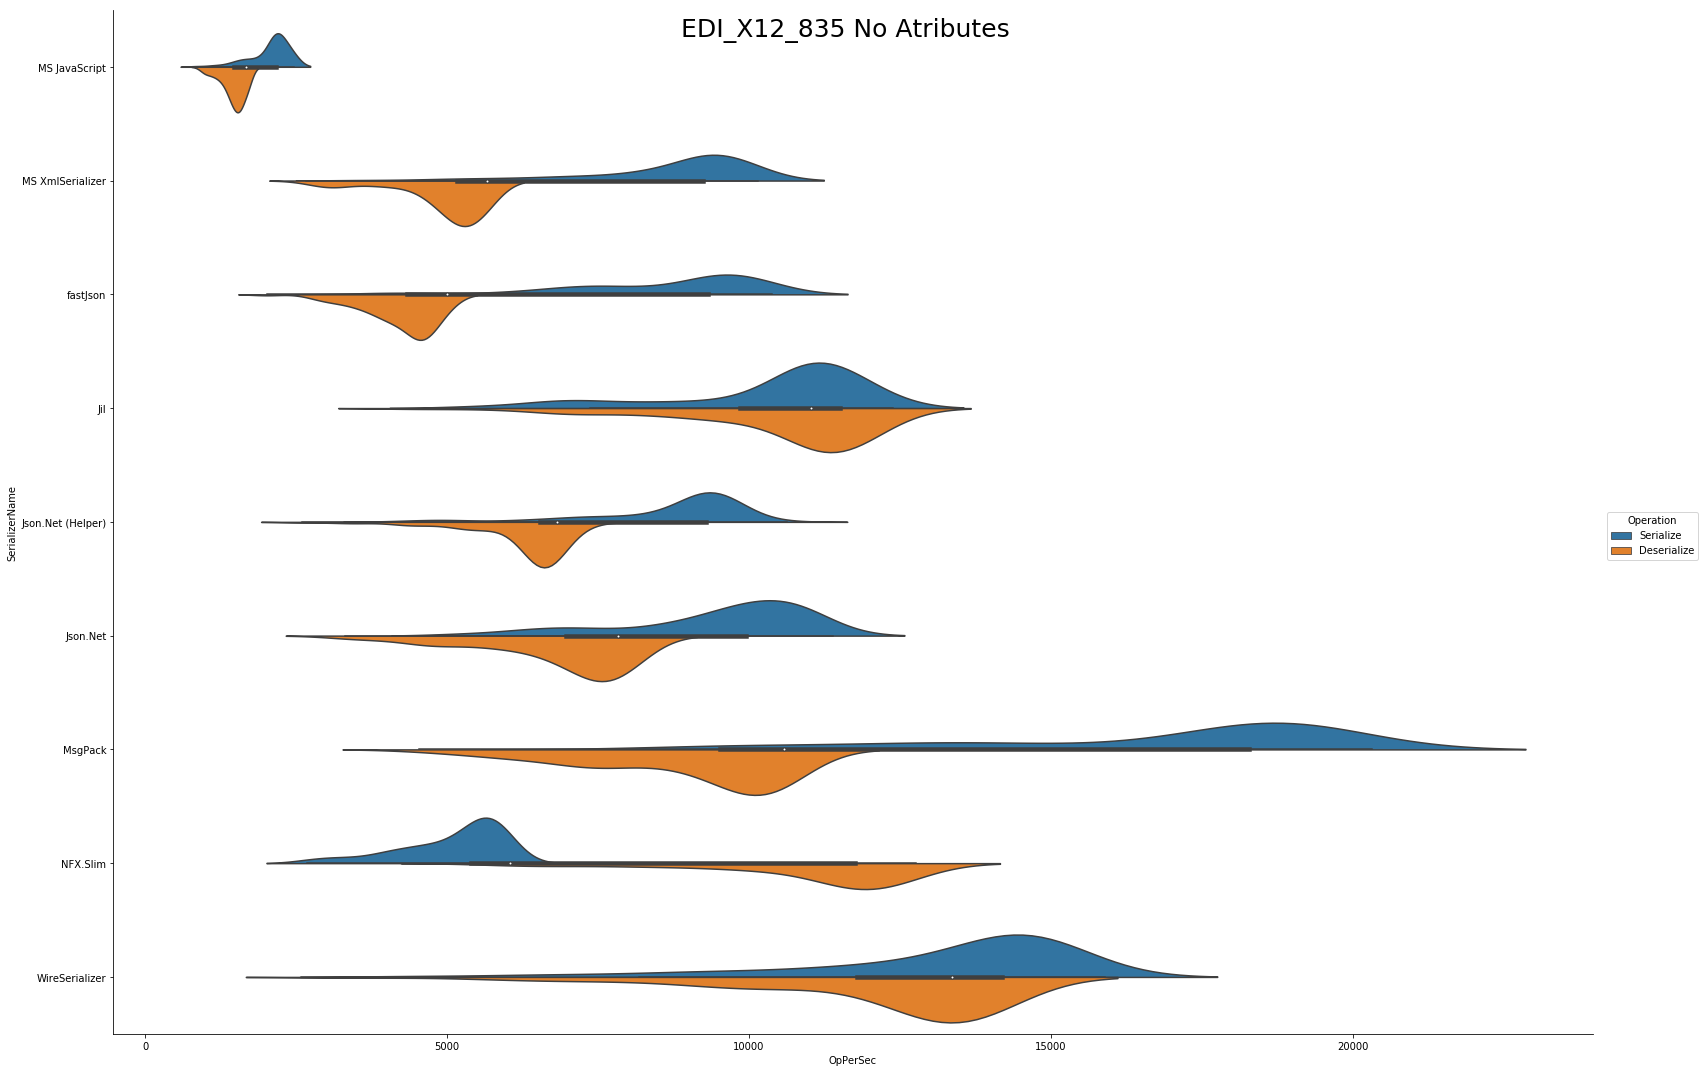

In [162]:
plot_serializers3(test_data_names[6])

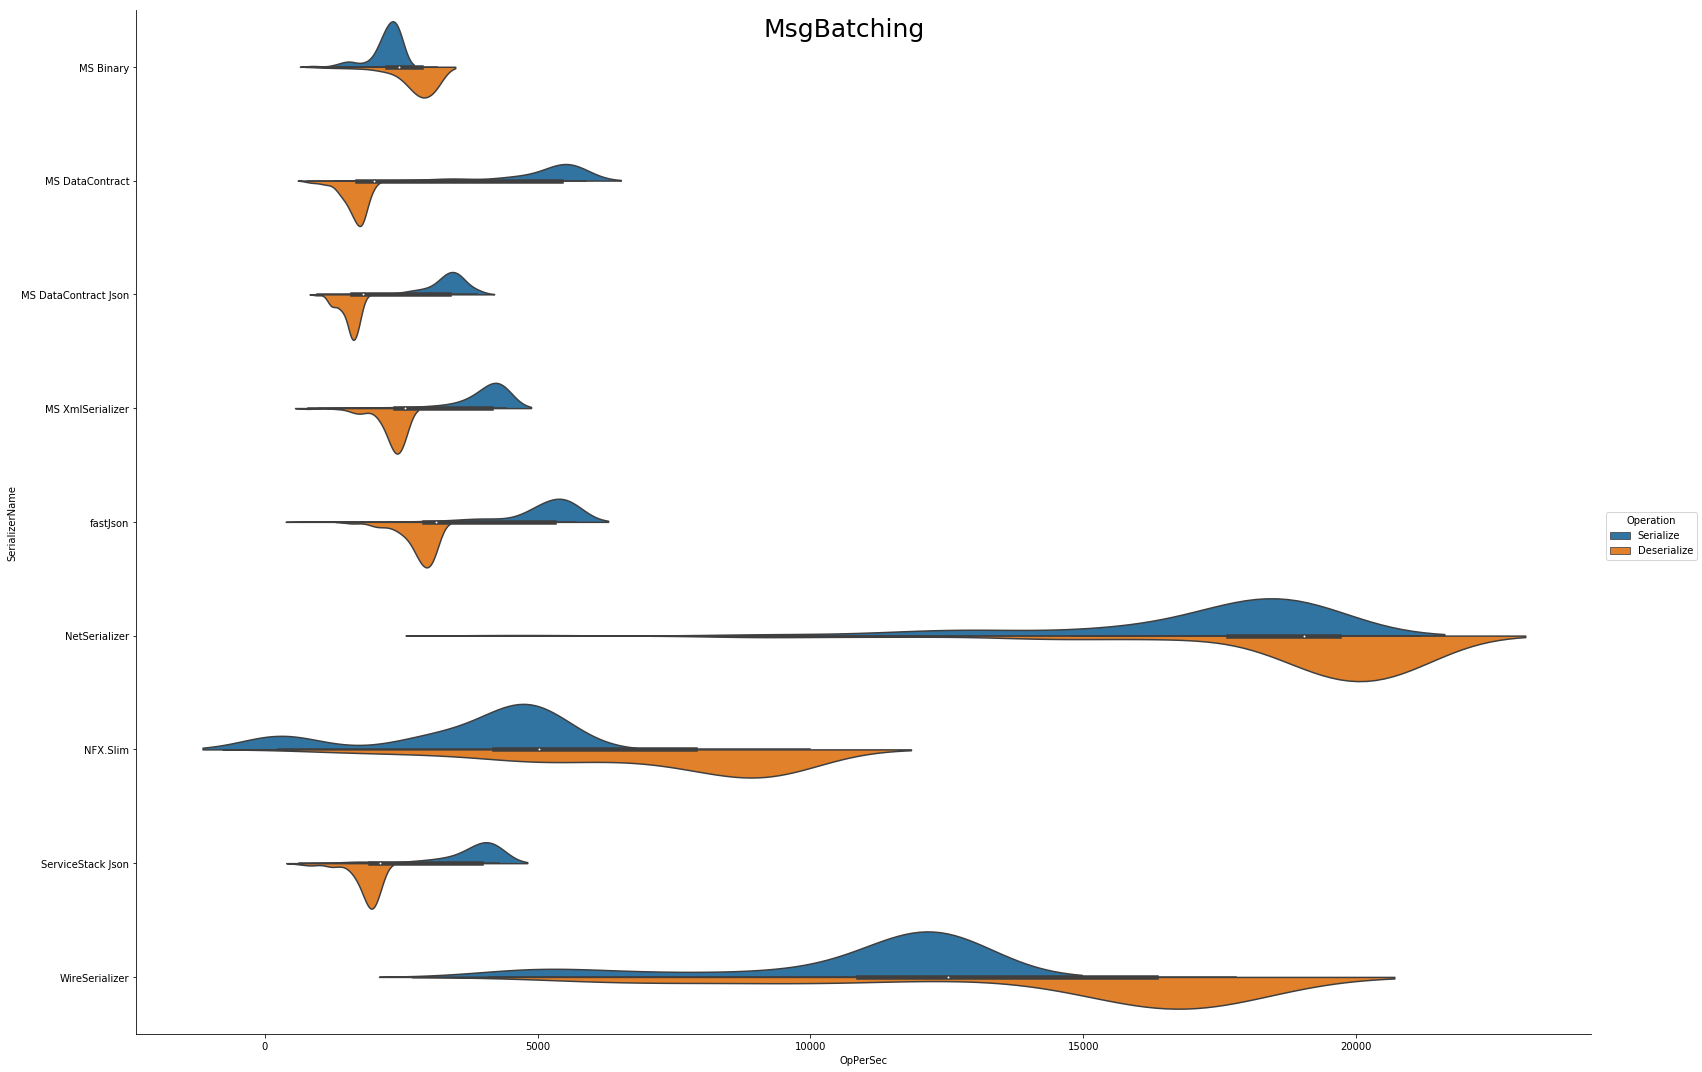

In [163]:
plot_serializers3(test_data_names[7])

## Conclusions:
- Serialization and Deserialization operations usualy perform with different speed.
- There is no generic rule. Some serializers run faster the serialization operation, some - run faster the deserialization operation.